# Análise dos dados do Corpus STRUCTURE PT-BR

Realiza a análise do conjunto de dados utilizando os arquivos:
- `corpus_especifico.zip`


# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )    

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.3 MB/s 
     |████████████████████████████████| 168 kB 59.6 MB/s 
     |████████████████████████████████| 182 kB 62.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 73.6 MB/s 
     |████████████████████████████████| 166 kB 67.8 MB/s 
     |████████████████████████████████| 162 kB 71.5 MB/s 
     |████████████████████████████████| 162 kB 74.8 MB/s 
     |████████████████████████████████| 158 kB 66.5 MB/s 
     |████████████████████████████████| 157 kB 67.0 MB/s 
     |████████████████████████████████| 157 kB 70.2 MB/s 
     |████████████████████████████████| 157 kB 58.4 MB/s 
     |████████████████████████████████| 157 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 52.0 MB/s 
     |████████████████████████████████| 157 kB 78.7 MB/s 
     |████████████████████████████

## 1.8 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [20]:
# Instala o spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.3
    Uninstalling wheel-0.38.3:
      Successfully uninstalled wheel-0.38.3
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [21]:
# Instala uma versão específica
!pip install -U spacy==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.6/660.6 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
      Successfully uninstalled spacy-3.4.2
ERROR

## 1.9 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face. 

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [22]:
!pip install -U transformers==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 55.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=fc73472a424c848008091322e4226ca08efb175e3216807f99b1bd9a248f430f
  Stored in directory: /root/.cache/pip/wheels/5b/e0/77/05245143a5b31f65af6a21f7afd3219e9fa4896f918af45677
Successfully built sacremoses


# 2 Parametrização

## Gerais

## Específicos

Parâmetros do modelo

In [23]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",

    versao_modelo_spacy = "3.2.0",
    
    sentenciar_documento = True,
    do_lower_case = False, # default True  
)

## Nome do diretório dos arquivos de dados

In [24]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_PTBR"

## Define o caminho para os arquivos de dados

In [25]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [26]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

https://spacy.io/models/pt

### Função download modelo spaCy

In [27]:
def downloadSpacy(model_args):
    """
      Realiza o download do arquivo do modelo para o diretório corrente.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
        
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Nome arquivo compactado
    NOME_ARQUIVO_MODELO_COMPACTADO = ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    # Url do arquivo
    URL_ARQUIVO_MODELO_COMPACTADO = "https://github.com/explosion/spacy-models/releases/download/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + NOME_ARQUIVO_MODELO_COMPACTADO

    # Realiza o download do arquivo do modelo
    logging.info("Download do arquivo do modelo do spaCy.")
    downloadArquivo(URL_ARQUIVO_MODELO_COMPACTADO, DIRETORIO_COHEBERT + "/" + NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.2 Descompacta o arquivo do modelo

### Função descompacta modelo spaCy

In [28]:
# Import das bibliotecas.
import tarfile # Biblioteca de descompactação

def descompactaSpacy(model_args):
    """
      Descompacta o arquivo do modelo.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    
    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    
    # Nome do arquivo a ser descompactado
    NOME_ARQUIVO_MODELO_COMPACTADO = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    logging.info("Descompactando o arquivo do modelo do spaCy.")
    arquivo_tar = tarfile.open(NOME_ARQUIVO_MODELO_COMPACTADO, "r:gz")    
    arquivo_tar.extractall(DIRETORIO_COHEBERT)    
    arquivo_tar.close()
    
    # Apaga o arquivo compactado
    if os.path.isfile(NOME_ARQUIVO_MODELO_COMPACTADO):        
        os.remove(NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.3 Carrega o modelo

### Função carrega modelo spaCy

In [29]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

def carregaSpacy(model_args):
    """
    Realiza o carregamento do Spacy.
    
    Parâmetros:
      `model_args` - Objeto com os argumentos do modelo.           
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
                  
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Caminho raoz do modelo do spaCy
    DIRETORIO_MODELO_SPACY =  DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY

    # Verifica se o diretório existe
    if os.path.exists(DIRETORIO_MODELO_SPACY) == False:
        # Realiza o download do arquivo modelo do spaCy
        downloadSpacy(model_args)
        # Descompacta o spaCy
        descompactaSpacy(model_args)

    # Diretório completo do spaCy
    DIRETORIO_MODELO_SPACY = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + ARQUIVO_MODELO_SPACY + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/"

    # Carrega o spaCy. Necessário somente "tagger" para encontrar os substantivos
    nlp = spacy.load(DIRETORIO_MODELO_SPACY)
    logging.info("spaCy carregado.")

    # Retorna o spacy carregado
    return nlp 

### Carrega o modelo spaCy


In [30]:
# Carrega o modelo spaCy
nlp = carregaSpacy(model_args)

INFO:root:Diretório Cohebert criado: COHQUAD_INIT_PTBR
INFO:root:Download do arquivo do modelo do spaCy.
INFO:root:Download do arquivo: COHQUAD_INIT_PTBR/pt_core_news_lg-3.2.0.tar.gz.


  0%|          | 0.00/577M [00:00<?, ?B/s]

INFO:root:Descompactando o arquivo do modelo do spaCy.
INFO:root:spaCy carregado.


## 3.4 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [31]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [32]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 416.
{'tentei', 'é', 'veja', 'treze', 'estivemos', 'vais', 'és', 'boa', 'fazes', 'quieta', 'somente', 'quem', 'tua', 'agora', 'aos', 'dez', 'números', 'a', 'vossas', 'além', 'sim', 'inclusive', 'seu', 'tarde', 'na', 'mais', 'pontos', 'três', 'grupo', 'porquanto', 'comprido', 'pouca', 'numa', 'máximo', 'talvez', 'povo', 'qualquer', 'já', 'sexto', 'onze', 'então', 'ademais', 'bastante', 'vós', 'tanta', 'desde', 'fez', 'demais', 'estar', 'primeira', 'lado', 'ter', 'contudo', 'debaixo', 'tais', 'muitos', 'fazia', 'vezes', 'outra', 'momento', 'lugar', 'vossos', 'temos', 'questão', 'pois', 'dá', 'através', 'novos', 'sempre', 'não', 'cá', 'teus', 'inicio', 'sei', 'nós', 'sabe', 'são', 'nesta', 'segunda', 'nada', 'fará', 'nove', 'duas', 'for', 'estado', 'final', 'grande', 'as', 'à', 'ele', 'elas', 'nosso', 'apoio', 'pelas', 'somos', 'teu', 'poderá', 'nas', 'umas', 'um', 'saber', 'pelo', 'vêm', 'relação', 'desse', 'diante', 'outros', 'você', 'menor', 'muito', 'partir', 

### getVerbos
Localiza os verbos da sentença

In [33]:
# Import das bibliotecas.
import spacy   
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                                  
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar   
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ] 

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [               
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                   
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal       
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ] 

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar 
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}}, 
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar 
               ] 

matcherv = Matcher(nlp.vocab)
         
matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):    
  #Processa o período
  doc1 = nlp(periodo.text)
  
  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))
  
  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [34]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [35]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [36]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [37]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novo_dic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [38]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [39]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.pos_)

  return lista


### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [40]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista_tokens = []
  lista_postagging = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:    
    lista_tokens.append(token.text)
    lista_postagging.append(token.pos_)
    
  return lista_tokens, lista_postagging

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [41]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}
  
#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA" 
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [42]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [43]:
def getSentencaSalientePOS(sentenca, pos, tipoSaliente="NOUN"):
  
  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especeficado
    if pos[i] == tipoSaliente:
      lista.append(token)

  # Retorna o documento
  return lista

# 5 Estatísticas Corpus STRUCTURE

## 5.1 Carrega os corpus específico

### Especifica os nomes dos arquivos do corpus

In [44]:
# Nome do arquivo
NOME_ARQUIVO_CORPUS = "corpus_especifico.csv"
NOME_ARQUIVO_CORPUS_COMPACTADO = "corpus_especifico.zip"

### Copia os arquivos do Google Drive para o Colaboratory

In [45]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_CORPUS_COMPACTADO" "$DIRETORIO_LOCAL"
 
  logging.info("Terminei a cópia.")

INFO:root:Terminei a cópia.


Descompacta os arquivos

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [46]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_CORPUS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

INFO:root:Terminei a descompactação.


### Carrega os dados

In [47]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
df_corpus = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_CORPUS, sep=";", encoding="UTF-8")

print(len(df_corpus))

104


In [48]:
df_corpus.sample(5)

,topico,fonte,sentenca
44,pilha,Thomas Cormen,Cada uma das três operações sobre pilhas demor...
7,pilha,Thomas Cormen,As pilhas e filas são conjuntos dinâmicos nos ...
72,fila,Thomas Cormen,"Quando um elemento é colocado na fila, ele ocu..."
25,pilha,Thomas Cormen,(a) A pilha S tem á elementos.
41,pilha,Thomas Cormen,3 else topolS] <- topo[S]-1


## 5.2 Estatísticas Dados Originais

### 5.2.1 Processamento estatísticas



In [49]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_sentencas = []
stats_sentencas_pos = []
stats_pos_palavras_sentenca_documento =[]

print("Processando",len(df_corpus),"documentos")

total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
qtde_abaixo_512 = 0
total_2_ou_mais_locucoes_verbais = 0
sentencas_com_uma_palavra = 0

total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

dicionario_palavras = {}

# Barra de progresso dos documentos
df_corpus_bar = tqdm_notebook(df_corpus.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_corpus))

# Percorre os documentos
for i, linha_documento in df_corpus_bar:  

    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentenca"]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Aplica sentenciação do spacy no documento
    doc = nlp(lista_sentenca_documento) 

    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(list(doc.sents))

    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0

    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_pos_doc = []

    # Acumula a lista de  POS das sentenças
    stats_pos_palavras_sentenca = []
   
    for j, sentenca in enumerate(doc.sents):

      # Recupera a lista de tokens e pos do documento      
      sentenca_token, sentenca_pos = getListaTokensPOSSentenca(str(sentenca))
    
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        sentencas_com_uma_palavra = sentencas_com_uma_palavra + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Gera as postagging das palavras da sentença
      pos_palavras_sentenca = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging   
        pos_palavras_sentenca.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Estatísticas das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1
        
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da quantidade de palavras da Sentença
      stats_sentencas.append(
         {  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
         }
      )
      
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca
      
      # Guarda as pos da sentença 
      stats_pos_palavras_sentenca = stats_pos_palavras_sentenca + pos_palavras_sentenca

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_pos_doc.append(contaPosSentenca)

    # Acumula a postagging das sentenças do documento
    stats_pos_palavras_sentenca_documento = stats_pos_palavras_sentenca_documento + stats_pos_palavras_sentenca  

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística da divisão
    stats_documentos.append(
      { 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_pos.append([linha_documento[0], lista_pos_doc])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", sentencas_com_uma_palavra)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 104 documentos


Documentos:   0%|          | 0/104 [00:00<?, ? documento/s]

Total de Sentenças                             : 131
Total de Sentenças com uma palavra             : 7
Total de palavras                              : 2102
Total de palavras distintas                    : 615
Total de palavras sem stopwords                : 1243
Total de sentenças com Verbos(VERB)            : 78 sendo 59.54% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 81 sendo 61.83% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 95 sendo 72.52% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 96 sendo 73.28% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [50]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_palavras_pos = pd.DataFrame(stats_pos_palavras_sentenca_documento, columns=("id", "sentenca", "palavra", "pos")) 

In [51]:
dfstats_palavras_pos.sample(5)

,id,sentenca,palavra,pos
319,pilha,0,em,ADP
235,pilha,0,do,ADP
152,pilha,0,Java,PROPN
752,pilha,0,STACK-EMPTY(S,PROPN
810,fila,0,Computação,PROPN


### 5.2.2 Conjunto de dados



In [52]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_palavras_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SPACE,VERB,X
count,104,261,74,76,53,232,472,47,54,129,326,56,6,209,3
unique,73,42,36,16,4,30,190,16,17,76,14,13,2,136,2
top,primeiro,de,não,é,e,o,fila,1,que,FIFO,",",a,,tem,then
freq,7,76,14,32,35,46,37,11,27,11,88,17,5,8,2


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [53]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_documentos)

df_stats.describe(include="all")

,qtdesentencas,qtdepalavras,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas
count,104.00,104.00,104.00,104.0,104.00,104.00,104.00,104.00,104.0
mean,98.97,20.21,11.95,0.0,2.01,2.74,4.54,7.28,0.0
std,68.63,13.36,7.33,0.0,1.82,2.47,3.05,5.19,0.0
min,6.00,2.00,2.00,0.0,0.00,0.00,0.00,0.00,0.0
25%,32.75,9.75,7.00,0.0,0.75,1.00,2.00,3.00,0.0
50%,94.00,17.00,10.00,0.0,2.00,2.00,4.00,6.50,0.0
75%,142.50,28.25,15.00,0.0,3.00,4.00,7.00,11.00,0.0
max,297.00,71.00,49.00,0.0,7.00,9.00,13.00,21.00,0.0


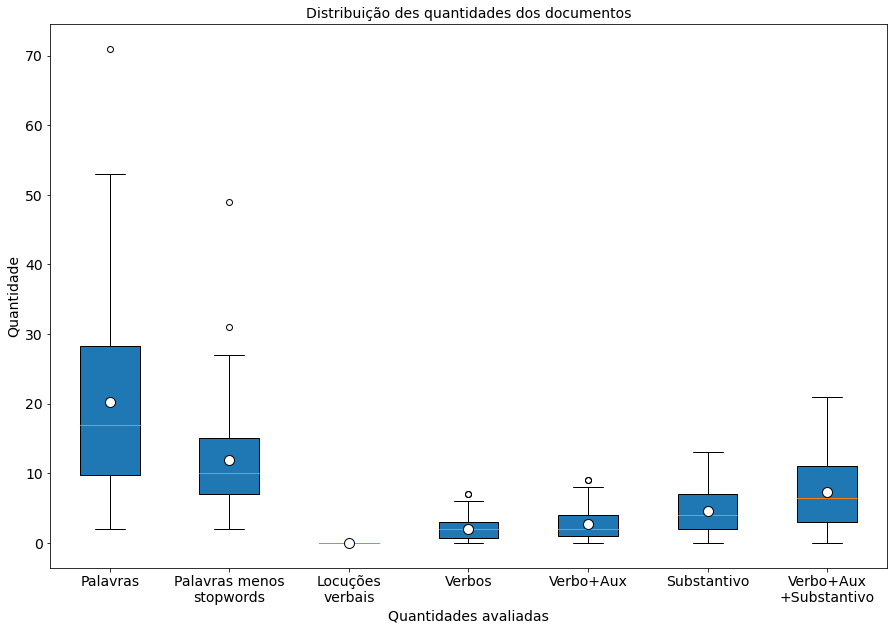

In [54]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [55]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_documentos_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_pos])

# Exibe as estatísticas
df_stats_documentos_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.0,104.00,104.0,2.00
mean,0.52,2.01,3.13,2.23,4.54,0.73,0.51,2.51,1.24,1.00,0.71,0.45,0.54,0.0,0.06,0.0,1.50
std,0.93,1.82,3.04,1.77,3.05,1.01,0.76,2.31,1.78,1.21,1.08,0.68,0.88,0.0,0.23,0.0,0.71
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.00
25%,0.00,0.75,1.00,1.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.25
50%,0.00,2.00,2.00,2.00,4.00,0.00,0.00,2.00,1.00,1.00,0.00,0.00,0.00,0.0,0.00,0.0,1.50
75%,1.00,3.00,4.00,3.25,7.00,1.00,1.00,4.00,2.00,2.00,1.00,1.00,1.00,0.0,0.00,0.0,1.75
max,5.00,7.00,22.00,7.00,13.00,5.00,4.00,9.00,12.00,7.00,4.00,3.00,4.00,0.0,1.00,0.0,2.00


Organiza os dados para gerar o boxplot

In [56]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_documentos_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

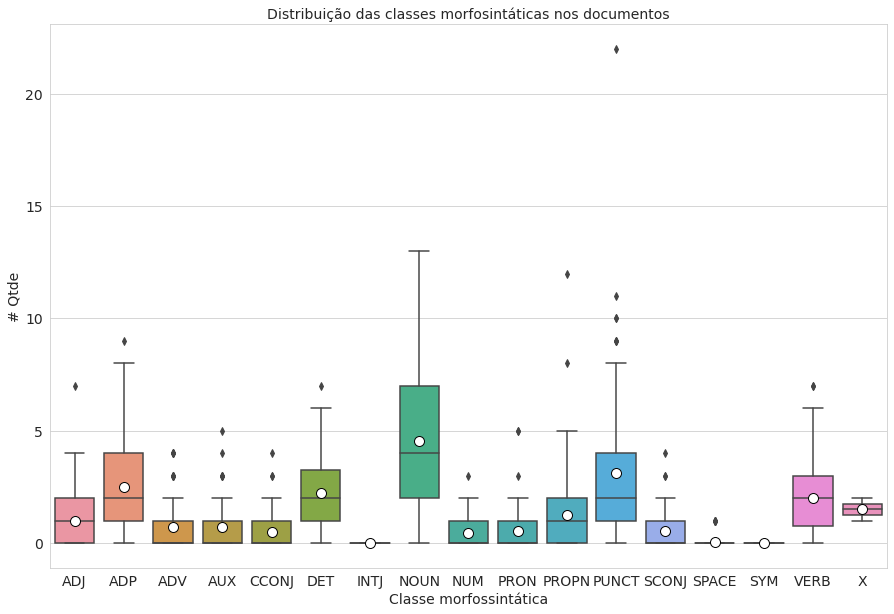

In [57]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_documentos_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_documentos_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

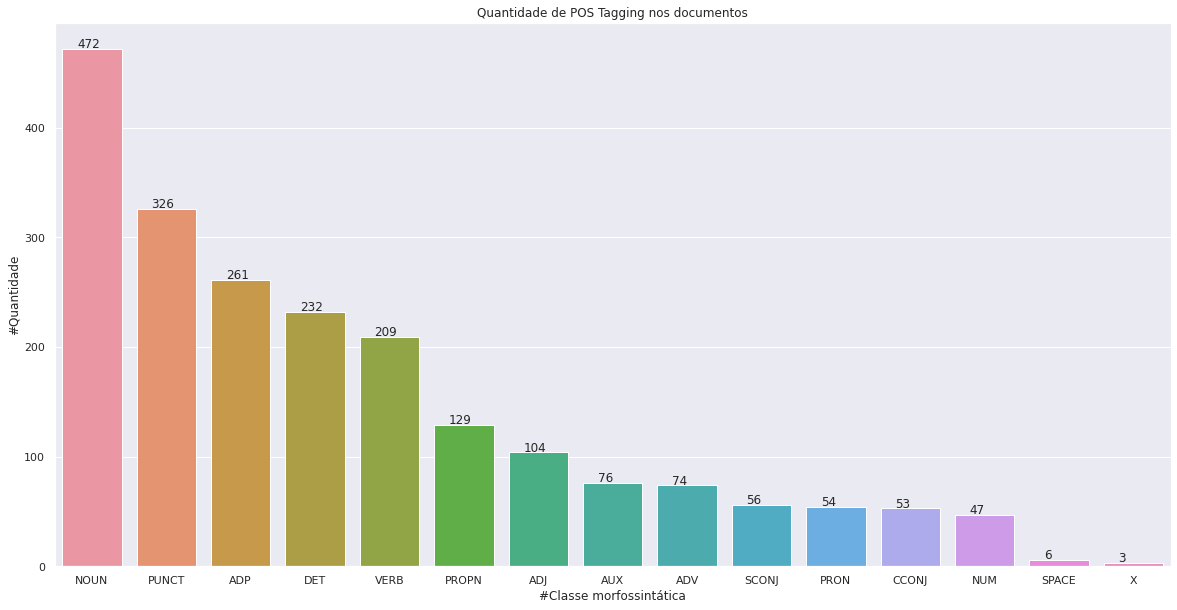

In [58]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_palavras_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_palavras_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [59]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

, => 88
de => 84
. => 79
a => 62
) => 49
o => 47
um => 42
] => 39
fila => 37
é => 35
e => 35
que => 35
( => 29
uma => 28
da => 27
pilha => 25
elemento => 24
em => 19
para => 17
A => 17


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [60]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,sentenca,qtdepalavras,qtdepalavrassemstopword,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo
count,131.00,131.00,131.00,131.00,131.00,131.00,131.00
mean,0.25,16.05,9.49,1.60,2.18,3.60,5.78
std,0.55,12.50,6.74,1.77,2.37,2.81,4.92
min,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.00,5.00,0.00,0.00,1.00,1.00
50%,0.00,13.00,8.00,1.00,1.00,3.00,5.00
75%,0.00,24.00,12.50,3.00,3.00,6.00,9.00
max,3.00,58.00,43.00,7.00,9.00,12.00,21.00


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


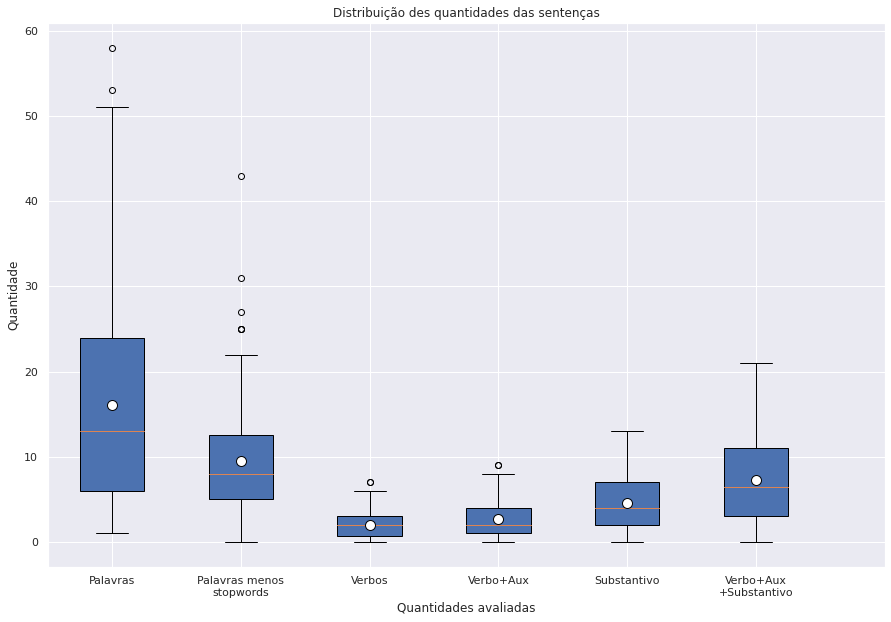

In [61]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],           
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Palavras menos\nstopwords",                      
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [62]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_pos])

# Exibe as estatísticas
df_stats_sentencas_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.00,131.0,131.00,131.0,2.00
mean,0.41,1.60,2.49,1.77,3.60,0.58,0.40,1.99,0.98,0.79,0.56,0.36,0.43,0.0,0.05,0.0,1.50
std,0.86,1.77,2.60,1.75,2.81,0.94,0.71,2.05,1.57,1.00,0.95,0.62,0.81,0.0,0.21,0.0,0.71
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.00
25%,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.25
50%,0.00,1.00,2.00,2.00,3.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.50
75%,1.00,3.00,3.00,3.00,6.00,1.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,0.0,0.00,0.0,1.75
max,5.00,7.00,21.00,7.00,12.00,5.00,4.00,8.00,12.00,4.00,4.00,3.00,4.00,0.0,1.00,0.0,2.00


In [63]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

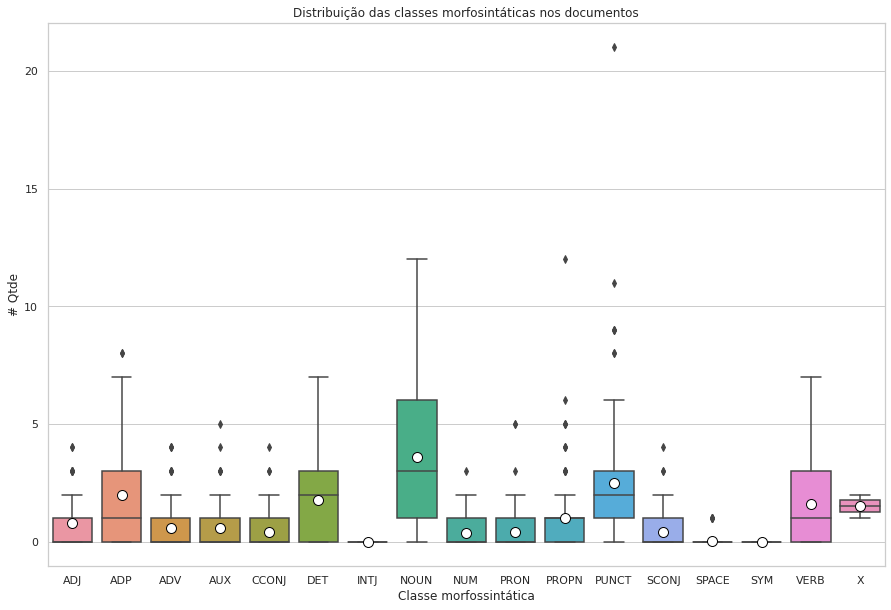

In [64]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

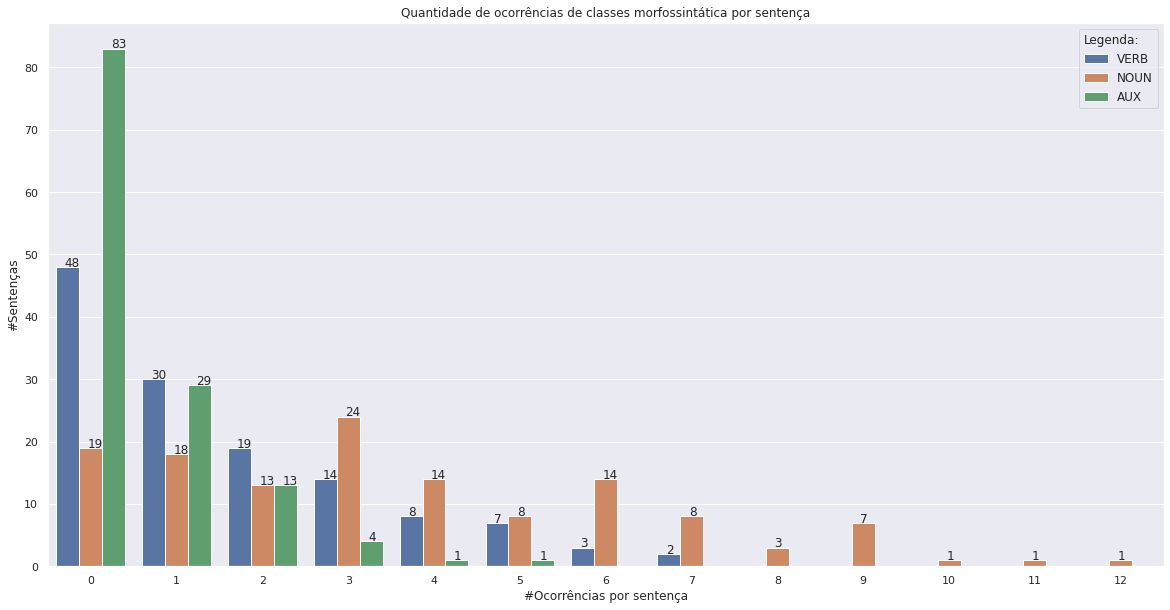

In [65]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_pos[df_stats_sentencas_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 20(#Sentenças) sentenças onde palavras da classe morfossintática verbo(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos POS Tagging de sentenças do documento original

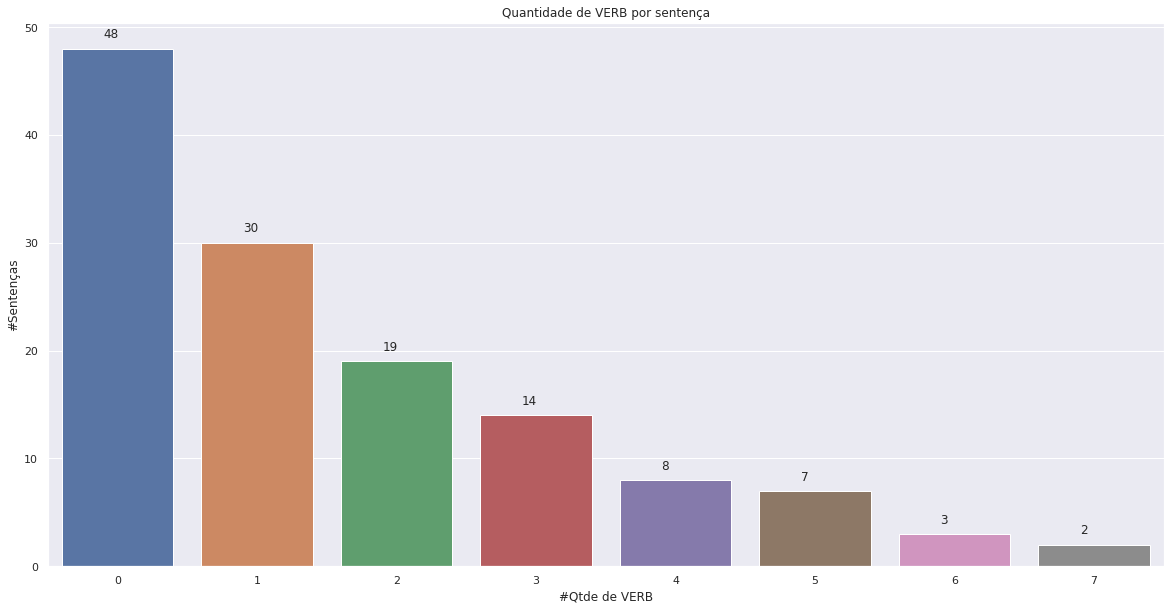

In [66]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

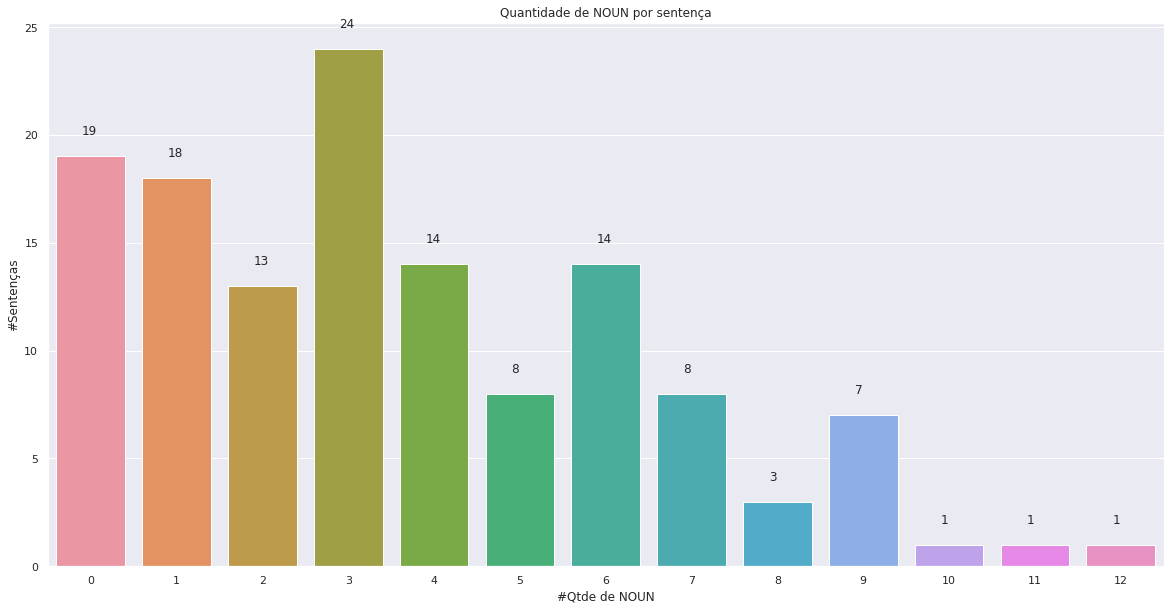

In [67]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

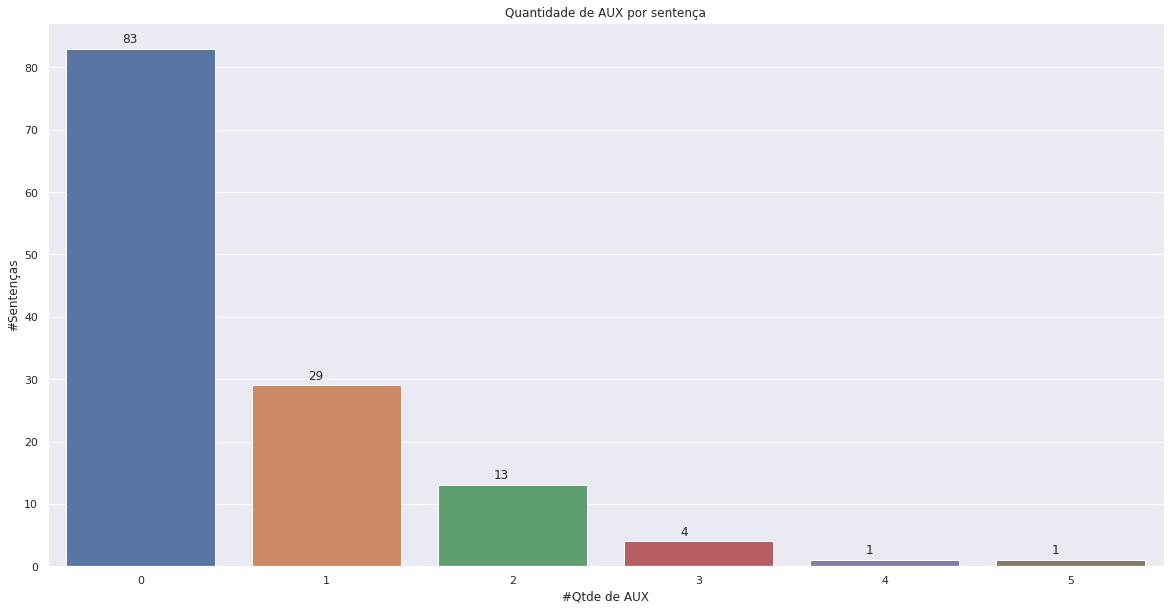

In [68]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

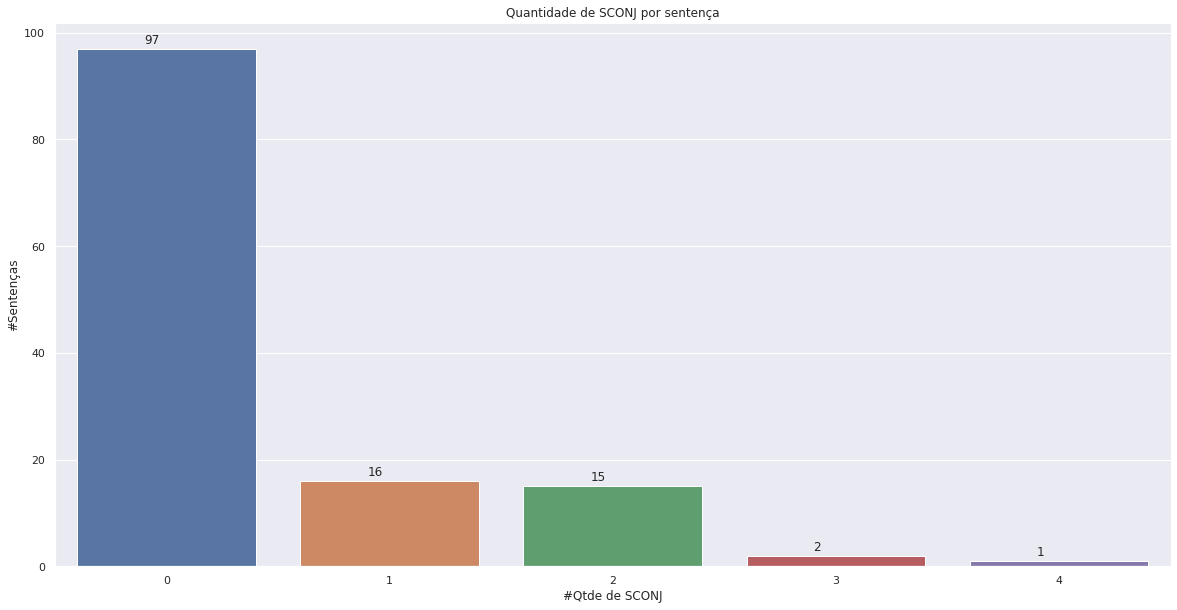

In [69]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

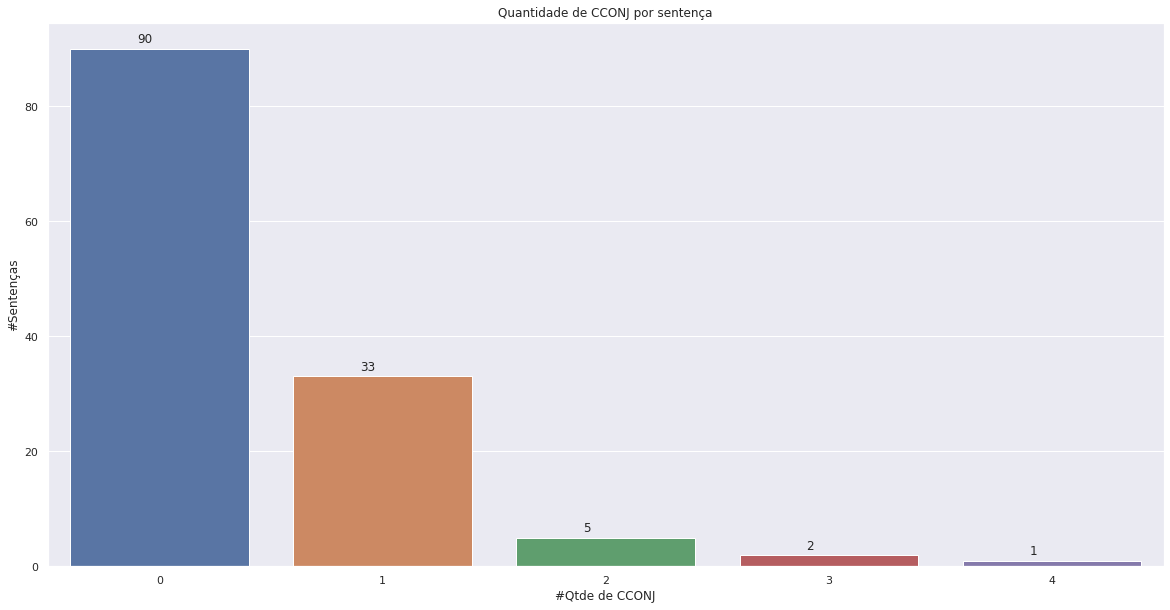

In [70]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

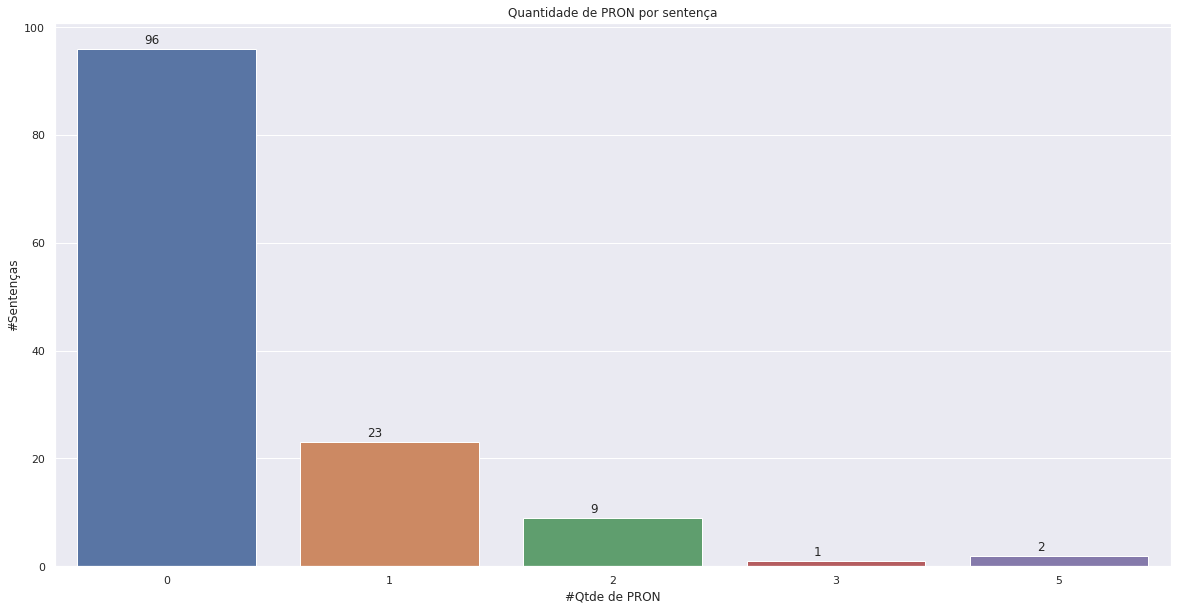

In [71]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Documento

#### 5.2.5.1 Gráfico Quantidade de documentos originais por quantidade de sentenças

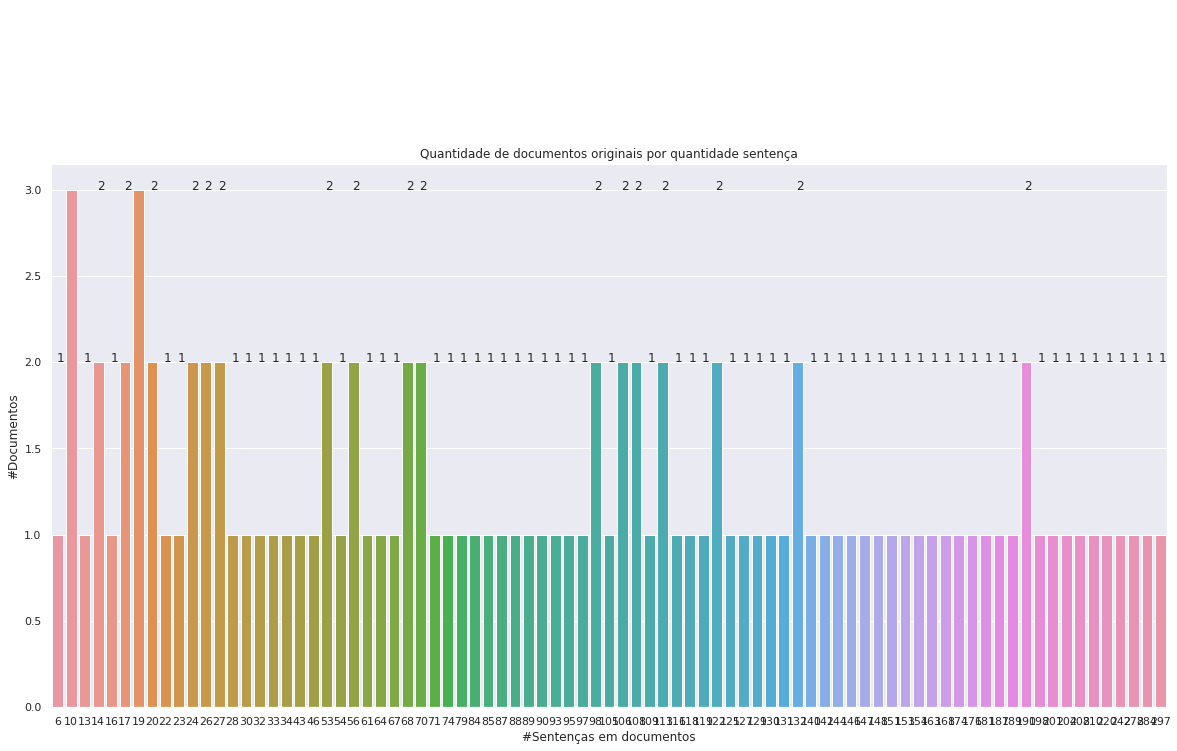

In [72]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.2 Gráfico Quantidade de documentos originais por quantidade de palavras

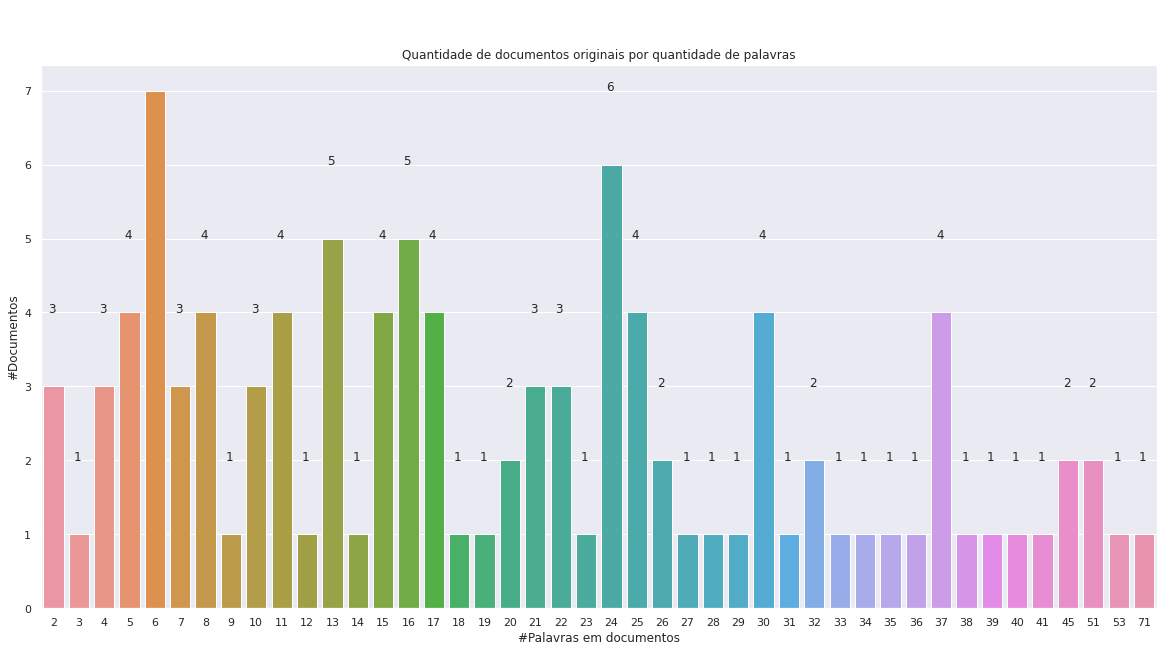

In [73]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.4 Gráfico Quantidade de documentos originais por quantidade de palavras desconsiderando as stopword

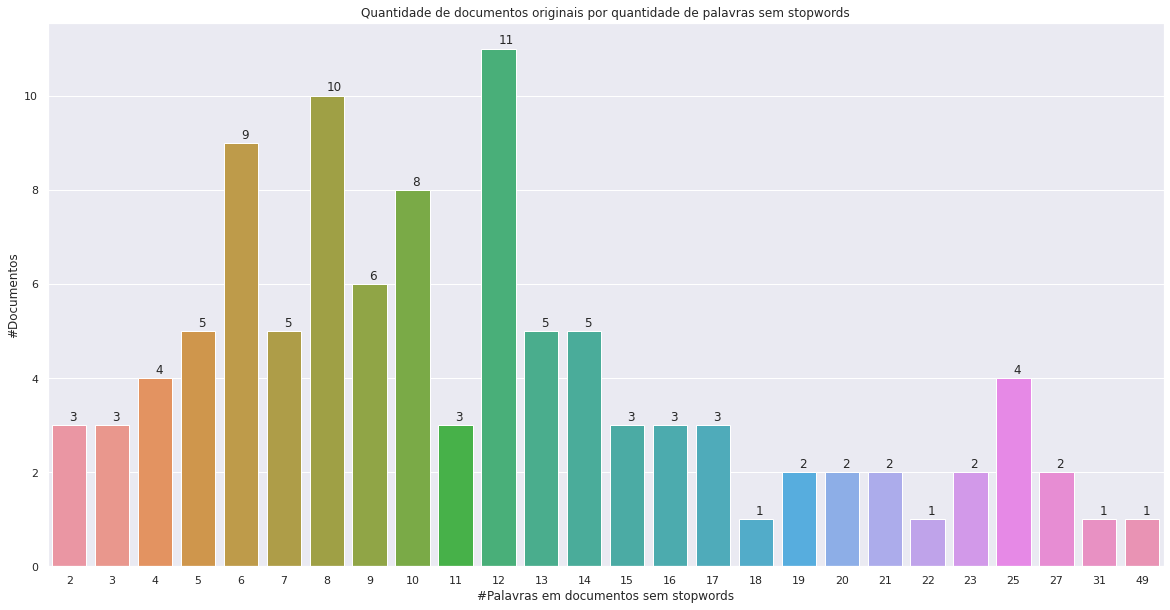

In [74]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.5 Gráfico Quantidade de documentos originais por quantidade de locuções verbais

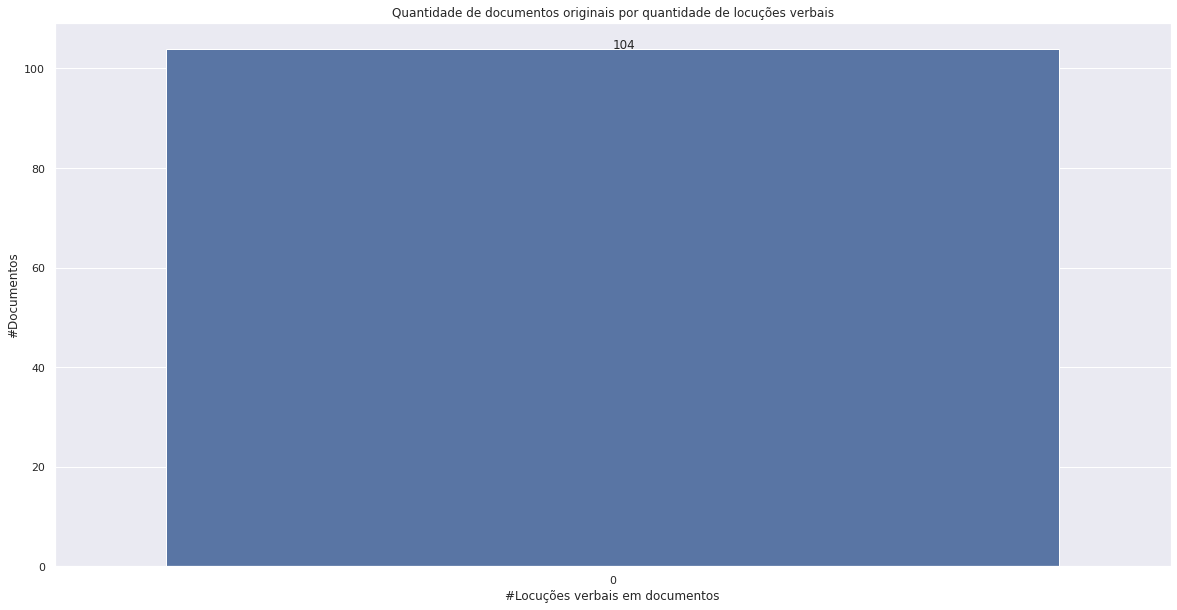

In [75]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.6 Gráfico Quantidade de documentos originais por quantidade de verbos

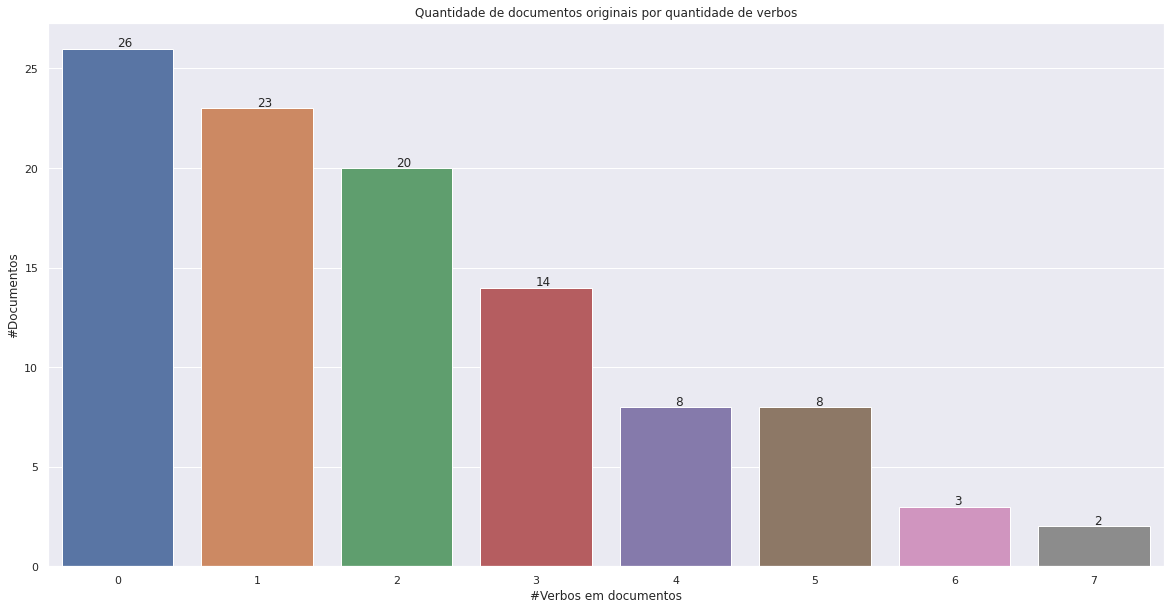

In [76]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.7 Gráfico Quantidade de documentos originais por quantidade de verbos e aux

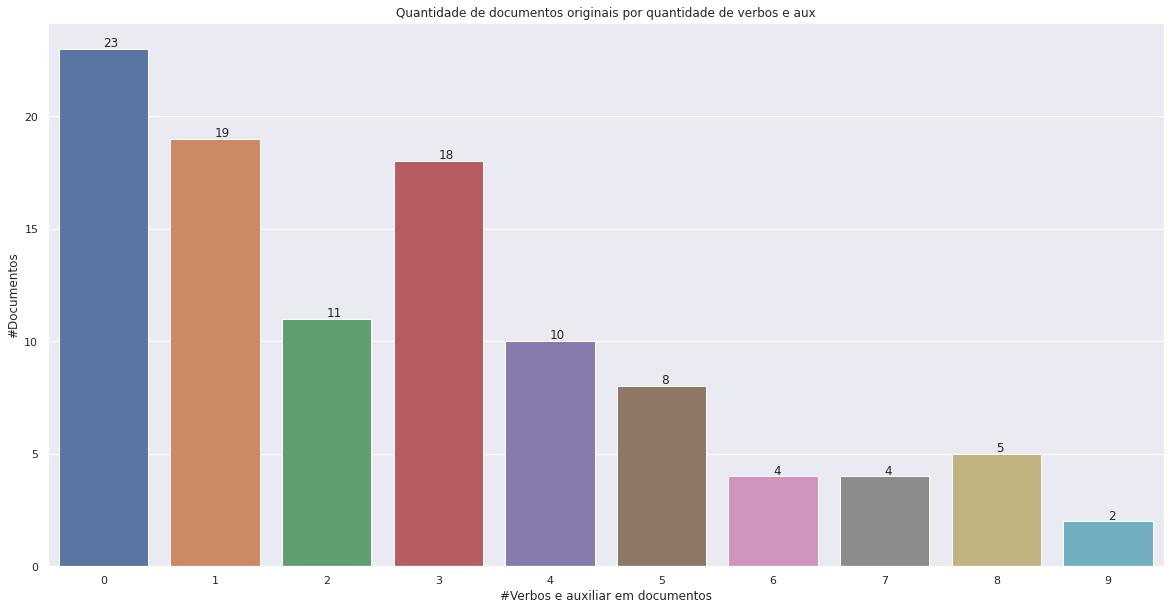

In [77]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.8 Gráfico Quantidade de documentos originais por quantidade de substantivos

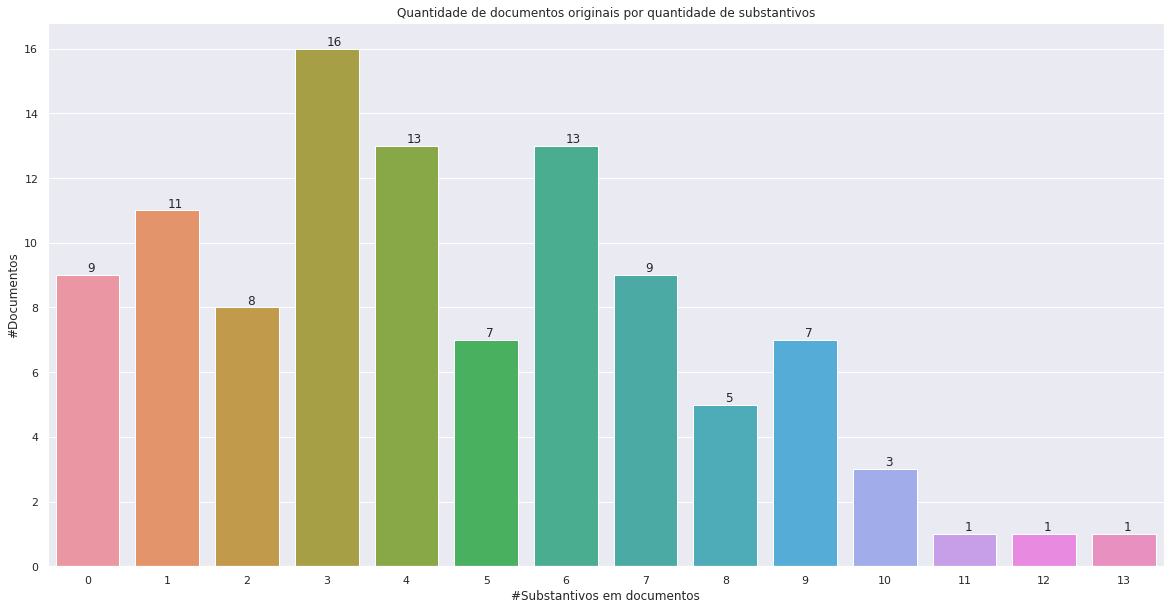

In [78]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.9 Gráfico Quantidade de documentos originais por quantidade de verbos(AUX) e substantivo

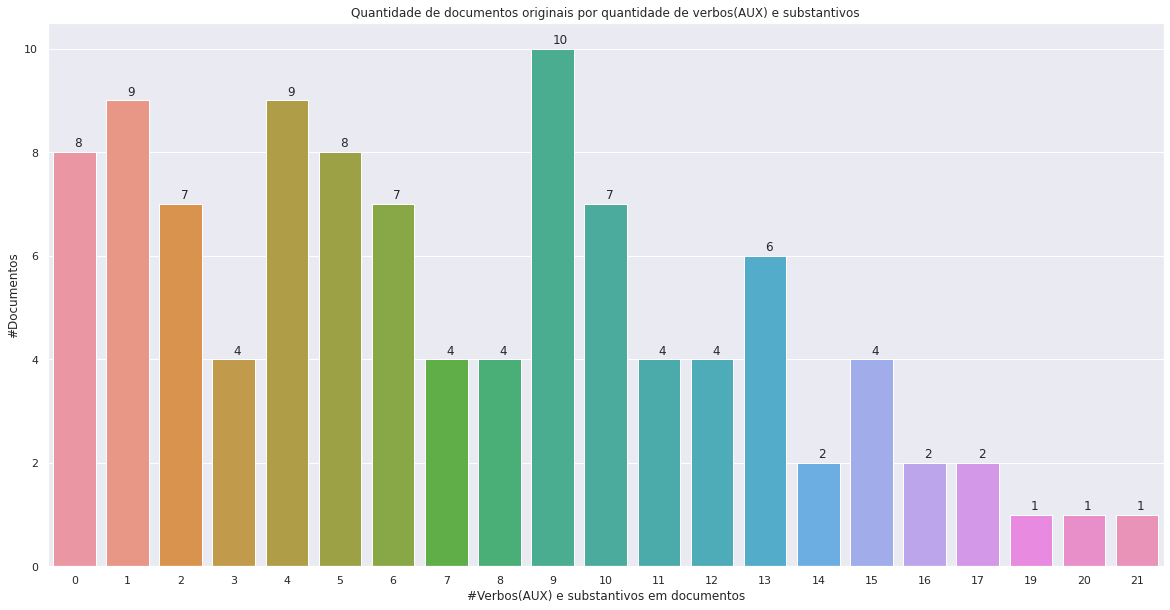

In [79]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

### 5.2.6 Por sentença

#### 5.2.6.1 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras

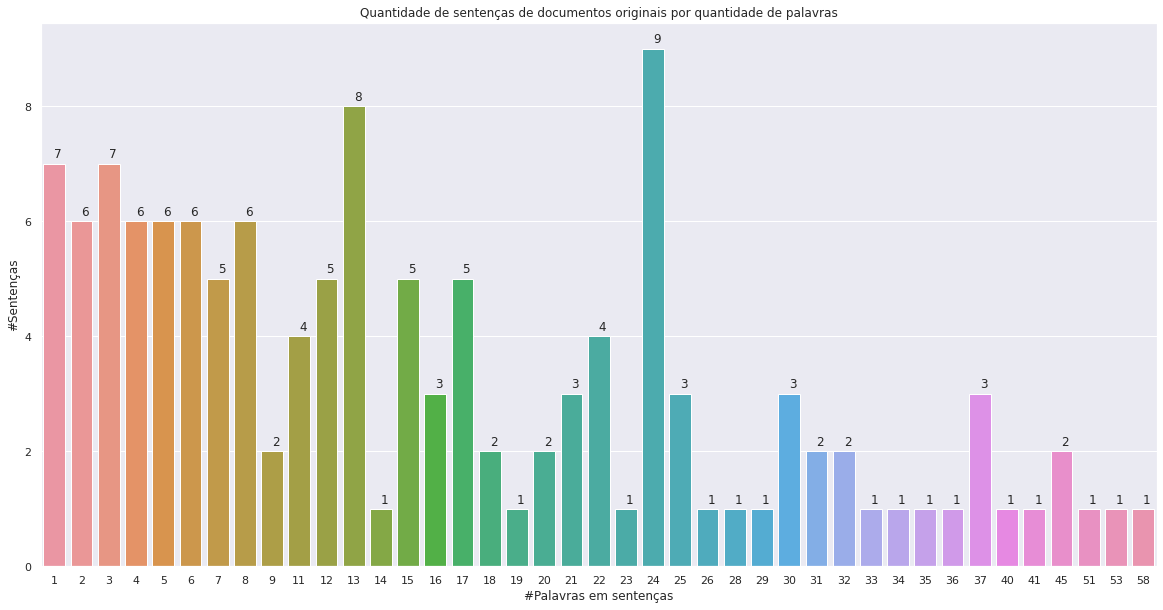

In [80]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopwords

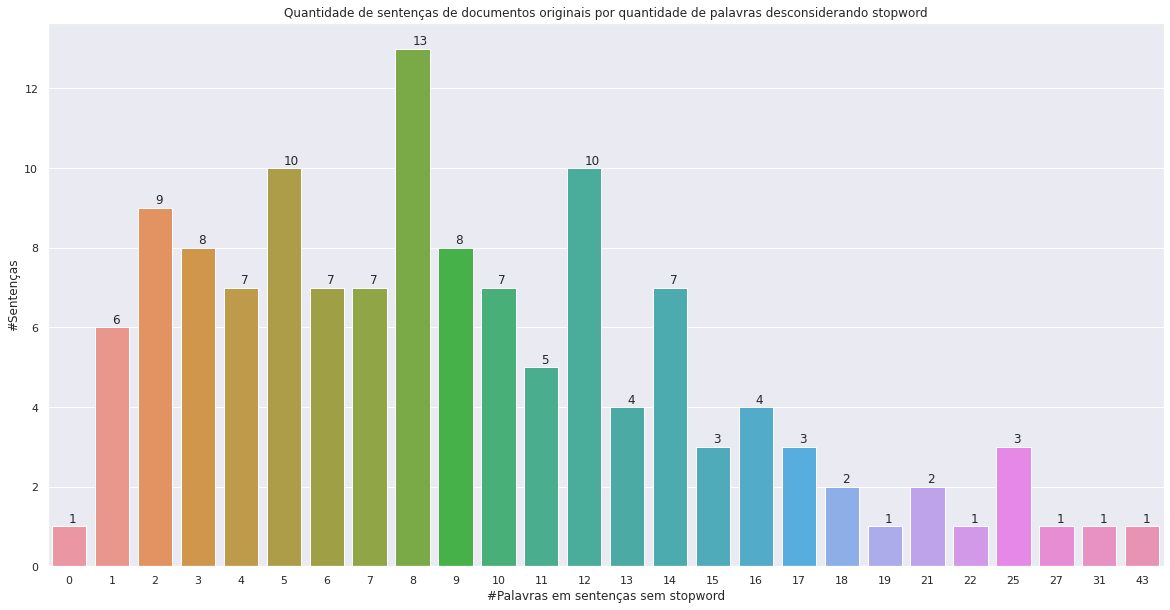

In [81]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos

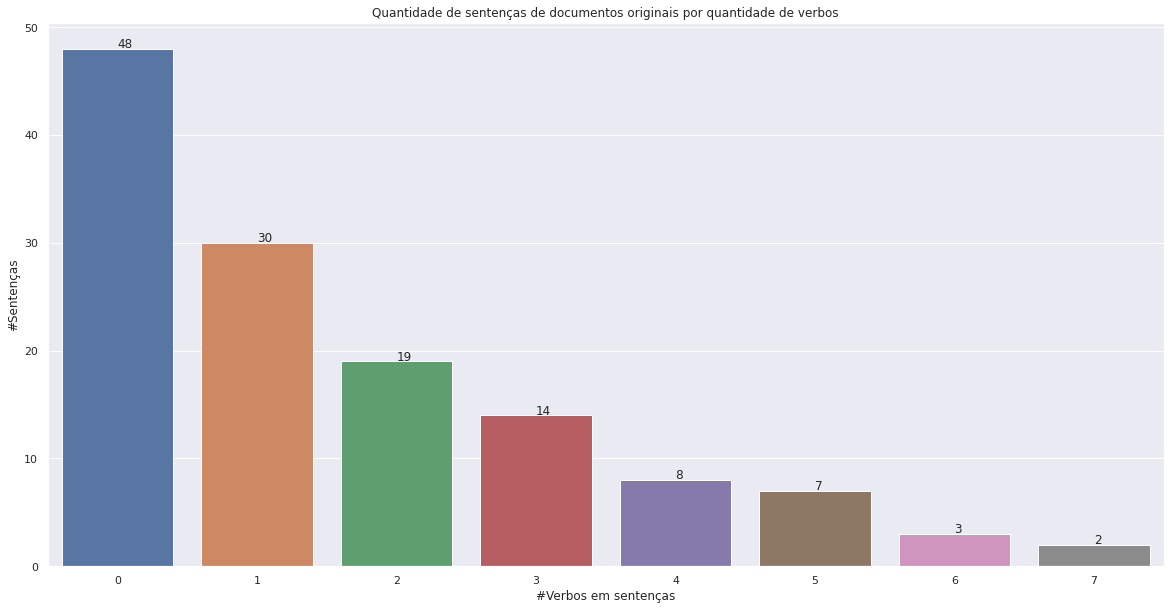

In [82]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos e aux

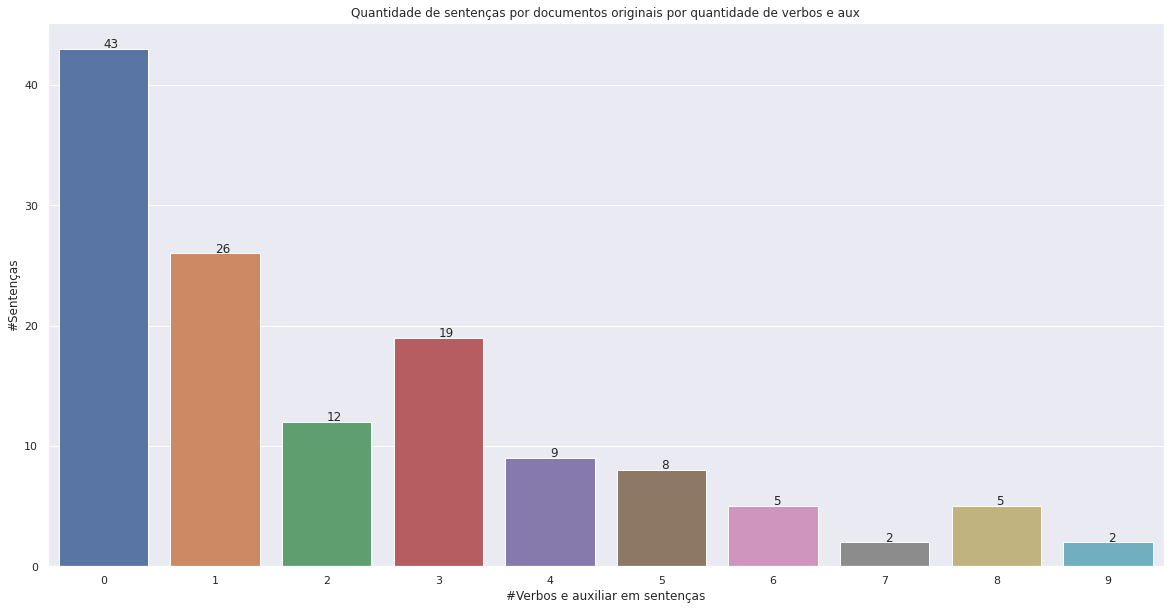

In [83]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de sentenças de documentos originais por quantidade de substantivos

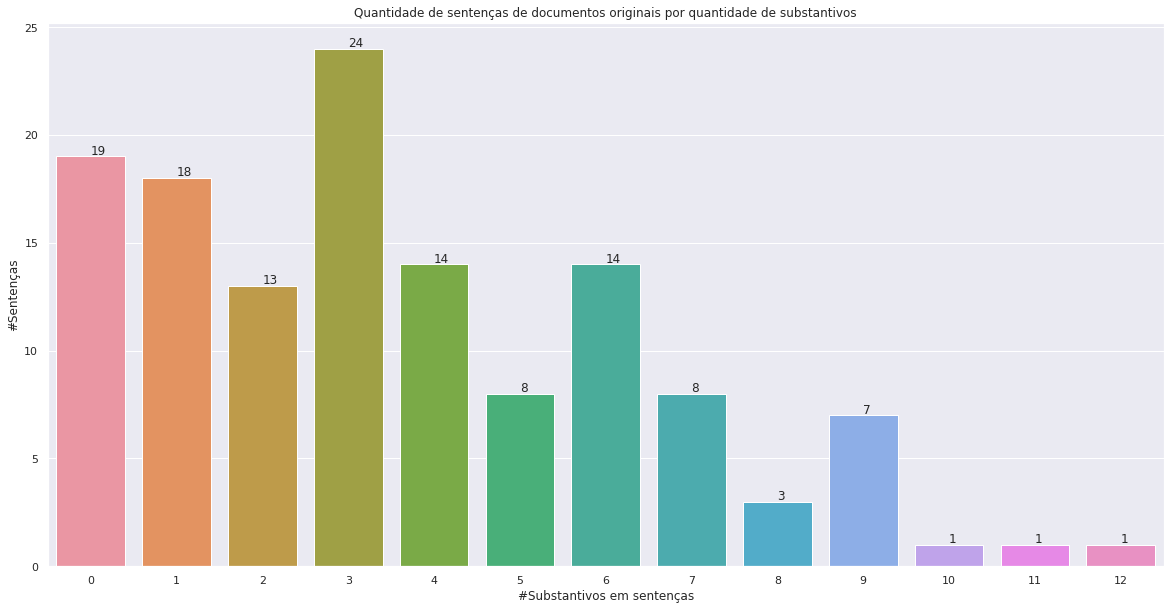

In [84]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivo

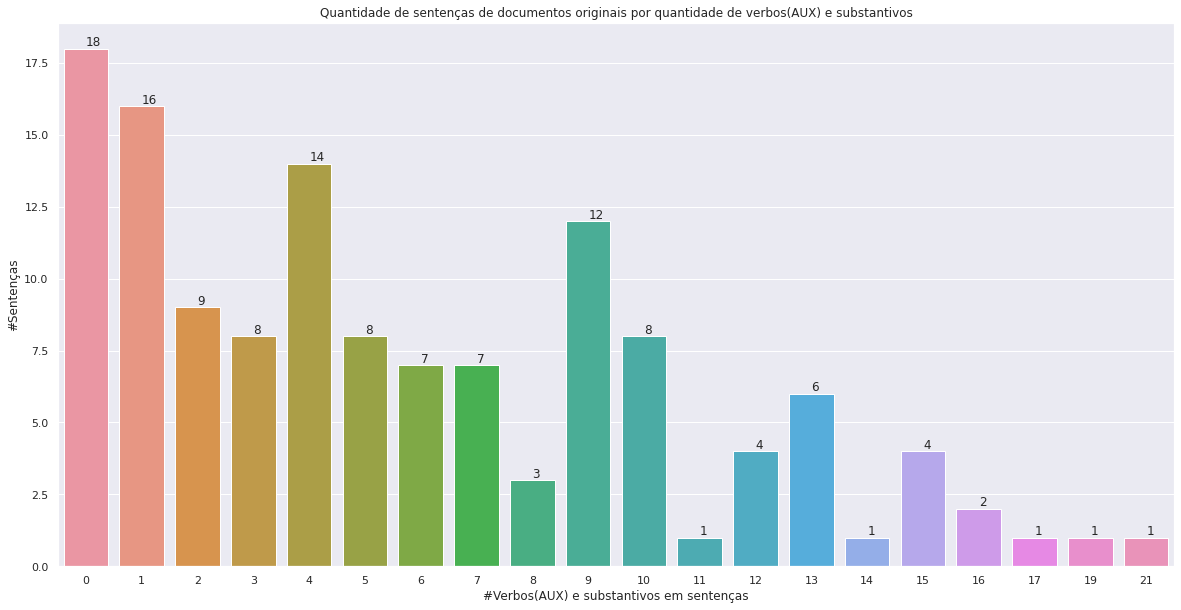

In [85]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento



In [86]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:05:31 (h:mm:ss)


# Análise dos dados do Corpus STRUCTURE en

Realiza a análise do conjunto de dados utilizando os arquivos:
- `corpus_especifico.zip`


# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [87]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [88]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [89]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [90]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [91]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [92]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [93]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [94]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [95]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )    

Biblioteca de limpeza de tela


In [96]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [97]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [98]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [99]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [100]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [101]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [102]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [103]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [104]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.7 Instalação do wandb

Instalação

In [105]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.8 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [106]:
# Instala o spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
# Instala uma versão específica
!pip install -U spacy==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.9 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face. 

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [108]:
!pip install -U transformers==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2 Parametrização

## Gerais

## Específicos

Parâmetros do modelo

In [109]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",

    versao_modelo_spacy = "3.2.0",
    
    sentenciar_documento = True,
    do_lower_case = False, # default True  
)

## Nome do diretório dos arquivos de dados

In [110]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_EN"

## Define o caminho para os arquivos de dados

In [111]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [112]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

https://spacy.io/models/pt

### Função download modelo spaCy

In [113]:
def downloadSpacy(model_args):
    """
      Realiza o download do arquivo do modelo para o diretório corrente.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
        
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Nome arquivo compactado
    NOME_ARQUIVO_MODELO_COMPACTADO = ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    # Url do arquivo
    URL_ARQUIVO_MODELO_COMPACTADO = "https://github.com/explosion/spacy-models/releases/download/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + NOME_ARQUIVO_MODELO_COMPACTADO

    # Realiza o download do arquivo do modelo
    logging.info("Download do arquivo do modelo do spaCy.")
    downloadArquivo(URL_ARQUIVO_MODELO_COMPACTADO, DIRETORIO_COHEBERT + "/" + NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.2 Descompacta o arquivo do modelo

### Função descompacta modelo spaCy

In [114]:
# Import das bibliotecas.
import tarfile # Biblioteca de descompactação

def descompactaSpacy(model_args):
    """
      Descompacta o arquivo do modelo.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    
    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    
    # Nome do arquivo a ser descompactado
    NOME_ARQUIVO_MODELO_COMPACTADO = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    logging.info("Descompactando o arquivo do modelo do spaCy.")
    arquivo_tar = tarfile.open(NOME_ARQUIVO_MODELO_COMPACTADO, "r:gz")    
    arquivo_tar.extractall(DIRETORIO_COHEBERT)    
    arquivo_tar.close()
    
    # Apaga o arquivo compactado
    if os.path.isfile(NOME_ARQUIVO_MODELO_COMPACTADO):        
        os.remove(NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.3 Carrega o modelo

### Função carrega modelo spaCy

In [115]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

def carregaSpacy(model_args):
    """
    Realiza o carregamento do Spacy.
    
    Parâmetros:
      `model_args` - Objeto com os argumentos do modelo.           
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
                  
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Caminho raoz do modelo do spaCy
    DIRETORIO_MODELO_SPACY =  DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY

    # Verifica se o diretório existe
    if os.path.exists(DIRETORIO_MODELO_SPACY) == False:
        # Realiza o download do arquivo modelo do spaCy
        downloadSpacy(model_args)
        # Descompacta o spaCy
        descompactaSpacy(model_args)

    # Diretório completo do spaCy
    DIRETORIO_MODELO_SPACY = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + ARQUIVO_MODELO_SPACY + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/"

    # Carrega o spaCy. Necessário somente "tagger" para encontrar os substantivos
    nlp = spacy.load(DIRETORIO_MODELO_SPACY)
    logging.info("spaCy carregado.")

    # Retorna o spacy carregado
    return nlp 

### Carrega o modelo spaCy


In [116]:
# Carrega o modelo spaCy
nlp = carregaSpacy(model_args)

INFO:root:Diretório Cohebert criado: COHQUAD_INIT_EN
INFO:root:Download do arquivo do modelo do spaCy.
INFO:root:Download do arquivo: COHQUAD_INIT_EN/en_core_web_lg-3.2.0.tar.gz.


  0%|          | 0.00/777M [00:00<?, ?B/s]

INFO:root:Descompactando o arquivo do modelo do spaCy.
INFO:root:spaCy carregado.


## 3.4 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [117]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [118]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 326.
{'latterly', 'my', 'that', 'last', 'why', 'quite', 'whole', 'nevertheless', 'ever', 'becomes', 'whereafter', '’d', 'onto', 'been', 'a', 'although', 'whereupon', '‘d', 'where', 'seemed', 'everything', "'m", 'could', 'further', 'become', 'fifty', 'another', 'without', 'down', 'whereby', 'can', 'various', 'there', 'whenever', 'between', 'side', 'of', 'might', 'around', 'into', 'afterwards', 'she', 'was', 'thru', 'each', '’m', 'whatever', '’s', 'somewhere', 'more', 'unless', 'beside', 'make', 'alone', 'back', 'hereby', 'it', 'thus', '‘s', 'done', '’ve', 'however', 'twenty', 'empty', 'doing', 'either', 'never', 'seems', "'re", 'always', 'two', '‘m', 'mine', 'am', 'except', 'whom', 'still', 'have', 'for', 'mostly', 'as', 'first', 'sixty', 're', 'among', 'had', 'us', 'becoming', 'be', '‘ve', 'their', 'just', 'than', 'here', 'least', 'anything', 'out', 'everywhere', 'also', 'third', 'ourselves', 'eight', 'does', 'keep', 'rather', 'enough', 'him', 'behind', 'is', '

### getVerbos
Localiza os verbos da sentença

In [119]:
# Import das bibliotecas.
import spacy   
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                                  
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar   
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ] 

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [               
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                   
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal       
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ] 

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar 
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}}, 
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar 
               ] 

matcherv = Matcher(nlp.vocab)
         
matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):    
  #Processa o período
  doc1 = nlp(periodo.text)
  
  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))
  
  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [120]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [121]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [122]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [123]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novo_dic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [124]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [125]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.pos_)

  return lista


### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [126]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista_tokens = []
  lista_postagging = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:    
    lista_tokens.append(token.text)
    lista_postagging.append(token.pos_)
    
  return lista_tokens, lista_postagging

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [127]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}
  
#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA" 
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [128]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [129]:
def getSentencaSalientePOS(sentenca, pos, tipoSaliente="NOUN"):
  
  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especeficado
    if pos[i] == tipoSaliente:
      lista.append(token)

  # Retorna o documento
  return lista

# 5 Estatísticas Corpus STRUCTURE

## 5.1 Carrega os corpus específico

### Especifica os nomes dos arquivos do corpus

In [130]:
# Nome do arquivo
NOME_ARQUIVO_CORPUS = "corpus_especifico.csv"
NOME_ARQUIVO_CORPUS_COMPACTADO = "corpus_especifico.zip"

### Copia os arquivos do Google Drive para o Colaboratory

In [131]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_CORPUS_COMPACTADO" "$DIRETORIO_LOCAL"
 
  logging.info("Terminei a cópia.")

INFO:root:Terminei a cópia.


Descompacta os arquivos

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [132]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_CORPUS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

INFO:root:Terminei a descompactação.


### Carrega os dados

In [133]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
df_corpus = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_CORPUS, sep=";", encoding="UTF-8")

print(len(df_corpus))

106


In [134]:
df_corpus.sample(5)

,topico,fonte,sentenca
6,pilha,wikipedia,"Push, which adds an element to the collection,..."
5,pilha,wikipedia,"In computer science, a stack is an abstract da..."
35,pilha,Thomas Cormen,3 else return FALSE
64,pilha,wikipedia,"Theoretically, one characteristic of a queue i..."
94,fila,Thomas Cormen,2 if Q.tail


## 5.2 Estatísticas Dados Originais

### 5.2.1 Processamento estatísticas



In [135]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_sentencas = []
stats_sentencas_pos = []
stats_pos_palavras_sentenca_documento =[]

print("Processando",len(df_corpus),"documentos")

total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
qtde_abaixo_512 = 0
total_2_ou_mais_locucoes_verbais = 0
sentencas_com_uma_palavra = 0

total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

dicionario_palavras = {}

# Barra de progresso dos documentos
df_corpus_bar = tqdm_notebook(df_corpus.iterrows(), desc=f"Documentos", unit=f" documento", total=len(df_corpus))

# Percorre os documentos
for i, linha_documento in df_corpus_bar:  

    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentenca"]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Aplica sentenciação do spacy no documento
    doc = nlp(lista_sentenca_documento) 

    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(list(doc.sents))

    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0

    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_pos_doc = []

    # Acumula a lista de  POS das sentenças
    stats_pos_palavras_sentenca = []
   
    for j, sentenca in enumerate(doc.sents):

      # Recupera a lista de tokens e pos do documento      
      sentenca_token, sentenca_pos = getListaTokensPOSSentenca(str(sentenca))
    
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        sentencas_com_uma_palavra = sentencas_com_uma_palavra + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Gera as postagging das palavras da sentença
      pos_palavras_sentenca = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging   
        pos_palavras_sentenca.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Estatísticas das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1
        
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da quantidade de palavras da Sentença
      stats_sentencas.append(
         {  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
         }
      )
      
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca
      
      # Guarda as pos da sentença 
      stats_pos_palavras_sentenca = stats_pos_palavras_sentenca + pos_palavras_sentenca

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_pos_doc.append(contaPosSentenca)

    # Acumula a postagging das sentenças do documento
    stats_pos_palavras_sentenca_documento = stats_pos_palavras_sentenca_documento + stats_pos_palavras_sentenca  

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística da divisão
    stats_documentos.append(
      { 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_pos.append([linha_documento[0], lista_pos_doc])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", sentencas_com_uma_palavra)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 106 documentos


Documentos:   0%|          | 0/106 [00:00<?, ? documento/s]

Total de Sentenças                             : 109
Total de Sentenças com uma palavra             : 0
Total de palavras                              : 1996
Total de palavras distintas                    : 519
Total de palavras sem stopwords                : 1114
Total de sentenças com Verbos(VERB)            : 81 sendo 74.31% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 85 sendo 77.98% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 99 sendo 90.83% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 103 sendo 94.50% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [136]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_palavras_pos = pd.DataFrame(stats_pos_palavras_sentenca_documento, columns=("id", "sentenca", "palavra", "pos")) 

In [137]:
dfstats_palavras_pos.sample(5)

,id,sentenca,palavra,pos
1912,fila,0,conditions,NOUN
1677,fila,0,the,DET
19,pilha,0,of,ADP
591,pilha,0,most,ADV
997,pilha,0,operation,NOUN


### 5.2.2 Conjunto de dados



In [138]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_palavras_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
count,109,201,66,107,58,260,491,48,34,65,39,264,39,5,195,15
unique,64,27,41,15,5,19,181,17,2,19,23,14,16,3,122,7
top,first,of,only,is,and,the,queue,1,to,which,Q,",",that,=,added,x
freq,9,59,4,39,30,128,37,13,27,13,4,93,6,3,9,4


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [139]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_documentos)

df_stats.describe(include="all")

,qtdesentencas,qtdepalavras,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas
count,106.00,106.00,106.00,106.0,106.00,106.00,106.00,106.00,106.0
mean,89.33,18.83,10.51,0.0,1.84,2.85,4.63,7.48,0.0
std,71.86,14.23,6.61,0.0,1.71,2.79,3.52,5.86,0.0
min,6.00,2.00,2.00,0.0,0.00,0.00,0.00,0.00,0.0
25%,33.75,9.00,6.00,0.0,1.00,1.00,2.00,4.00,0.0
50%,78.00,17.00,9.00,0.0,2.00,3.00,4.00,6.00,0.0
75%,120.00,25.50,13.75,0.0,3.00,4.00,6.00,10.00,0.0
max,476.00,95.00,46.00,0.0,9.00,16.00,21.00,37.00,0.0


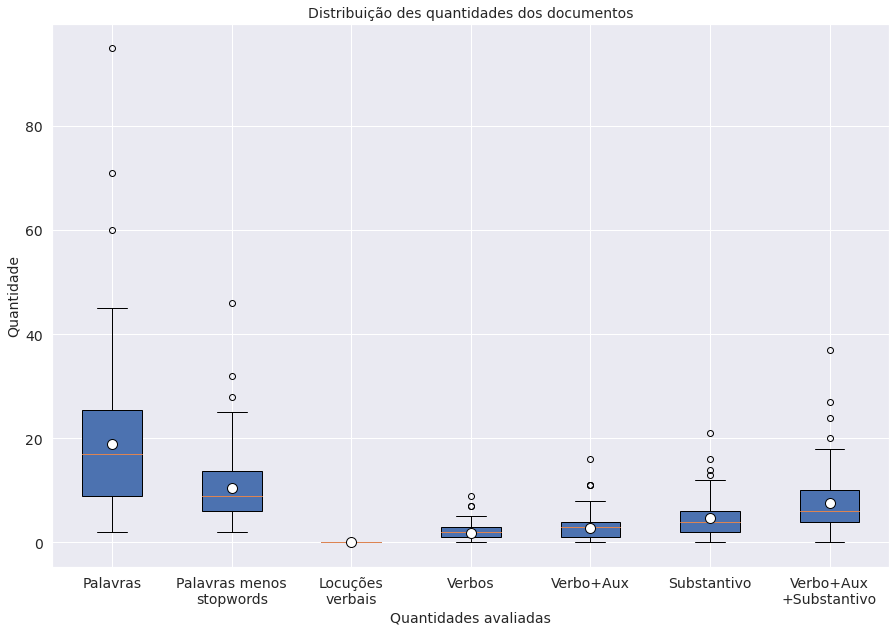

In [140]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [141]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_documentos_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_pos])

# Exibe as estatísticas
df_stats_documentos_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,PART,X
count,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.00,106.0,106.0,27.00,13.00
mean,0.61,1.84,2.49,2.45,4.63,1.01,0.55,1.90,0.37,1.03,0.62,0.45,0.37,0.05,0.0,0.0,1.26,1.15
std,0.95,1.71,1.96,2.51,3.52,1.55,0.87,2.42,0.64,1.20,0.99,0.73,0.61,0.21,0.0,0.0,0.53,0.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
25%,0.00,1.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
50%,0.00,2.00,2.00,2.00,4.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
75%,1.00,3.00,3.75,4.00,6.00,2.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00,0.00,0.0,0.0,1.00,1.00
max,6.00,9.00,9.00,12.00,21.00,9.00,5.00,14.00,3.00,7.00,4.00,3.00,3.00,1.00,0.0,0.0,3.00,2.00


Organiza os dados para gerar o boxplot

In [142]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_documentos_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

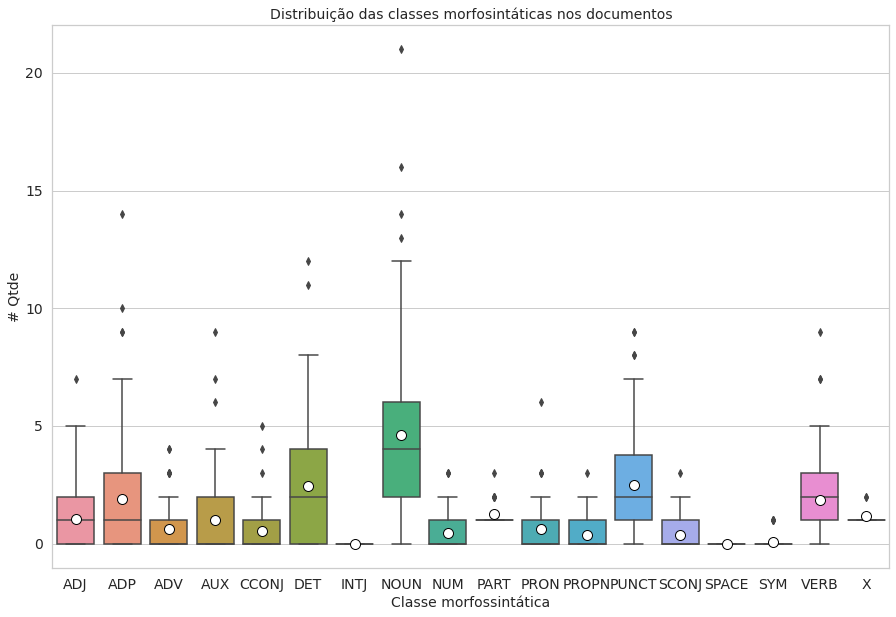

In [143]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_documentos_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_documentos_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

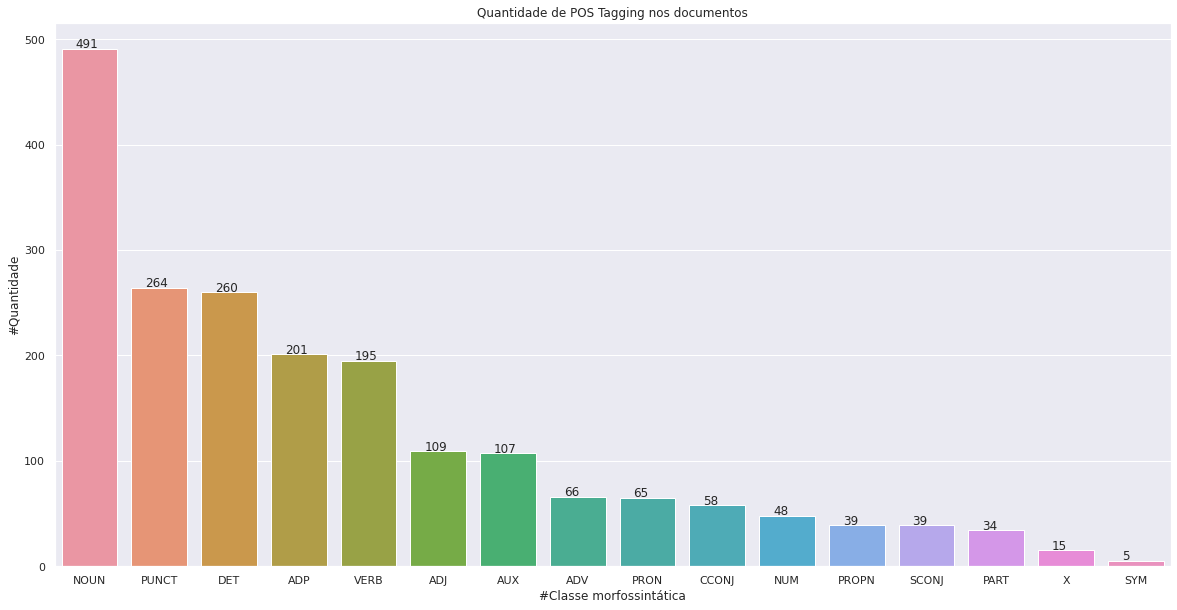

In [144]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_palavras_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_palavras_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [145]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

the => 128
, => 93
. => 80
a => 64
of => 59
to => 43
is => 39
queue => 37
stack => 34
in => 30
and => 30
element => 30
an => 25
) => 20
The => 20
- => 19
be => 17
or => 16
at => 16
that => 16


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [146]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,sentenca,qtdepalavras,qtdepalavrassemstopword,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo
count,109.00,109.00,109.00,109.00,109.00,109.00,109.00
mean,0.03,18.31,10.22,1.79,2.77,4.50,7.28
std,0.16,14.26,6.62,1.71,2.79,3.55,5.90
min,0.00,2.00,2.00,0.00,0.00,0.00,0.00
25%,0.00,7.00,5.00,0.00,1.00,2.00,3.00
50%,0.00,16.00,9.00,1.00,3.00,4.00,6.00
75%,0.00,24.00,13.00,3.00,4.00,6.00,10.00
max,1.00,95.00,46.00,9.00,16.00,21.00,37.00


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


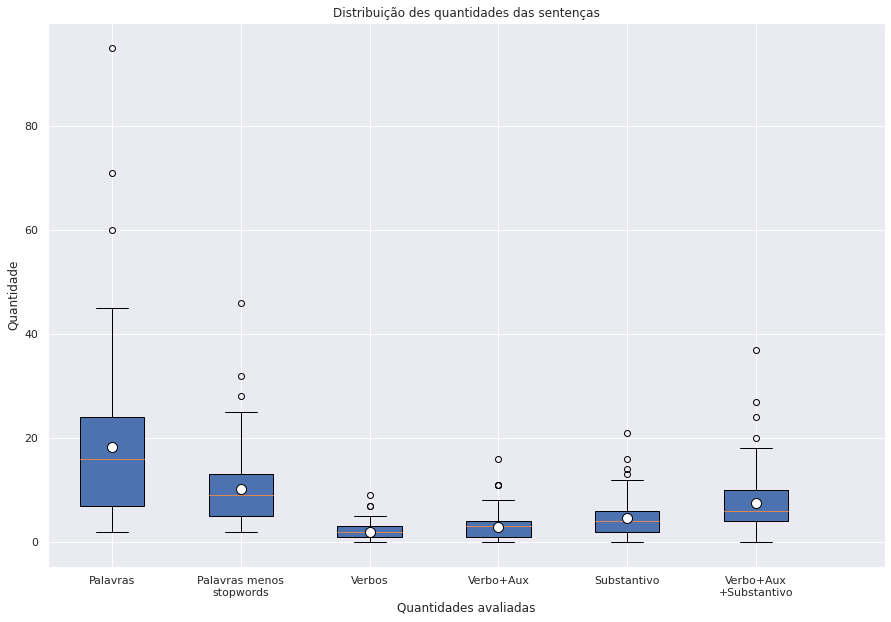

In [147]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],           
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Palavras menos\nstopwords",                      
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [148]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_pos])

# Exibe as estatísticas
df_stats_sentencas_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,PART,X
count,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.0,109.0,27.00,13.00
mean,0.60,1.79,2.42,2.39,4.50,0.98,0.53,1.84,0.36,1.00,0.61,0.44,0.36,0.05,0.0,0.0,1.26,1.15
std,0.94,1.71,1.86,2.51,3.55,1.53,0.87,2.41,0.63,1.19,0.98,0.73,0.60,0.21,0.0,0.0,0.53,0.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
25%,0.00,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
50%,0.00,1.00,2.00,2.00,4.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,1.00
75%,1.00,3.00,3.00,4.00,6.00,2.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00,0.00,0.0,0.0,1.00,1.00
max,6.00,9.00,9.00,12.00,21.00,9.00,5.00,14.00,3.00,7.00,4.00,3.00,3.00,1.00,0.0,0.0,3.00,2.00


In [149]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

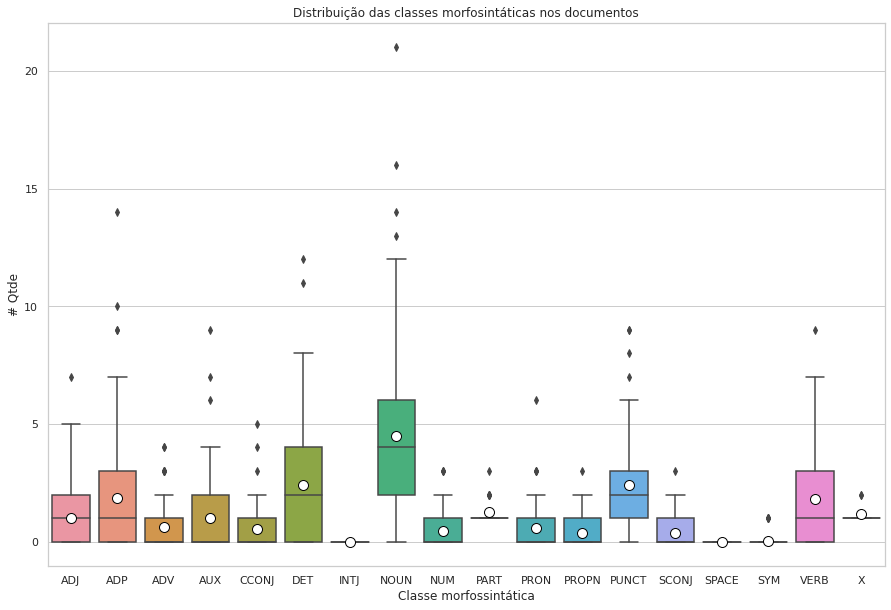

In [150]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

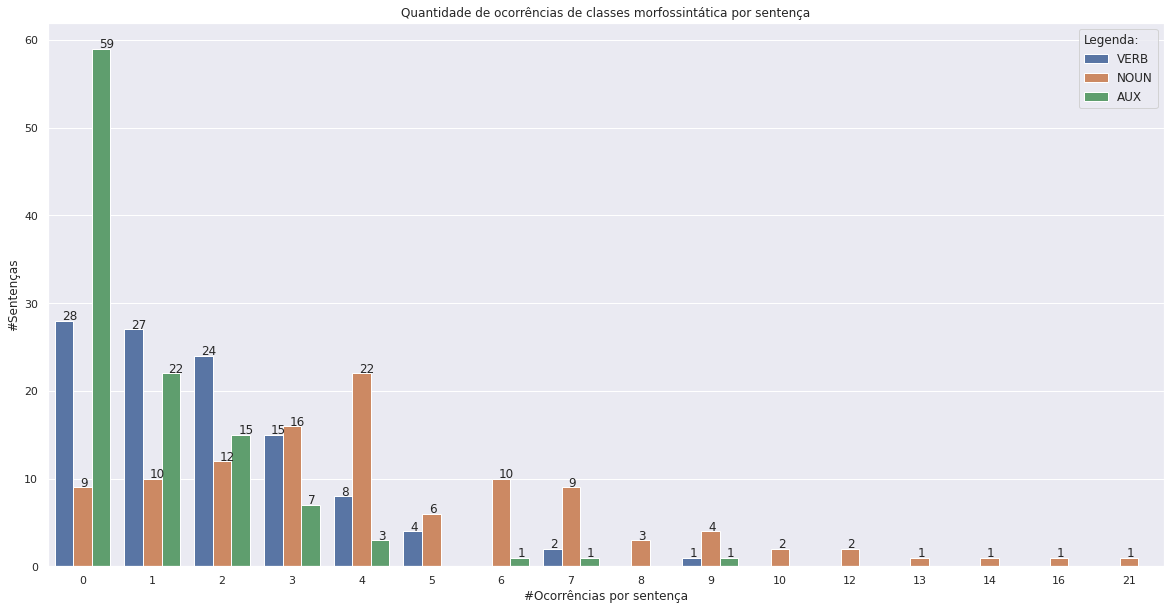

In [151]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_pos[df_stats_sentencas_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 20(#Sentenças) sentenças onde palavras da classe morfossintática verbo(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos POS Tagging de sentenças do documento original

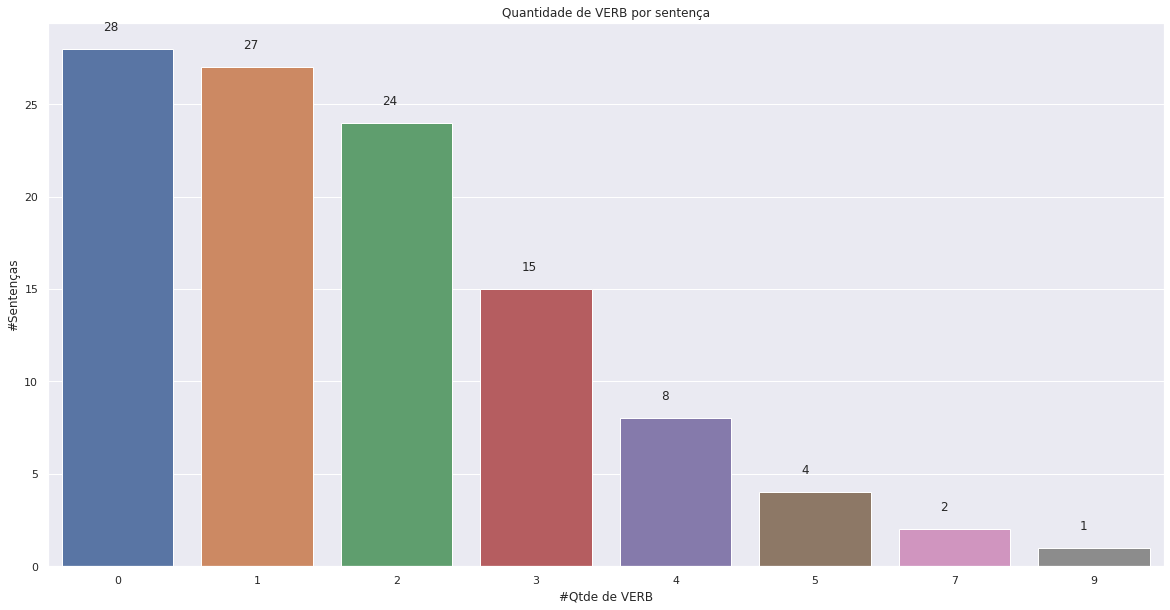

In [152]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

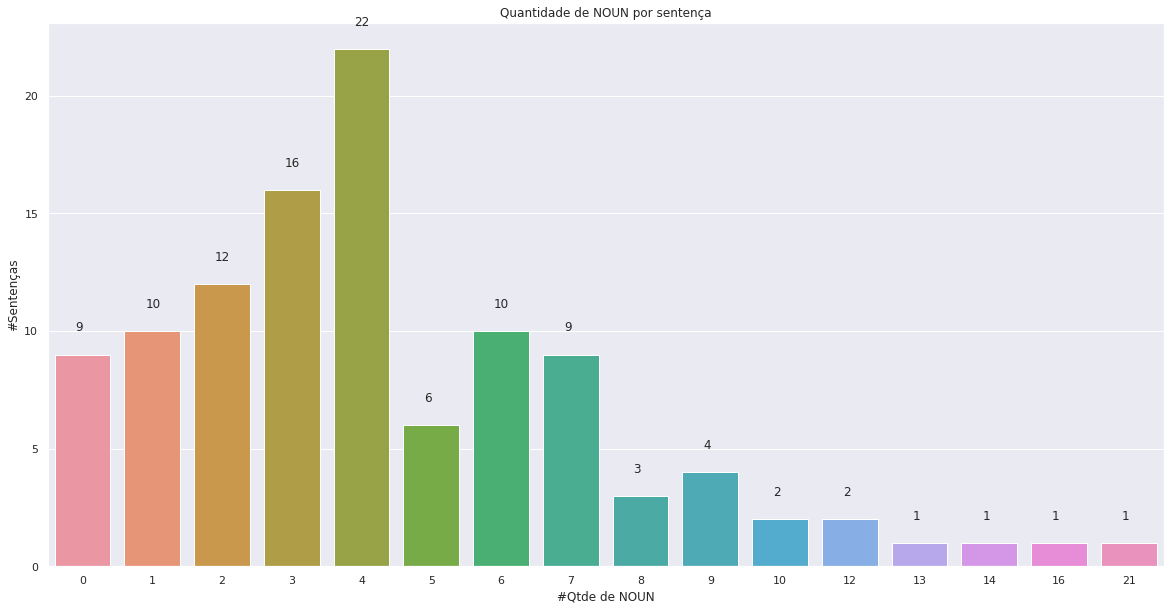

In [153]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

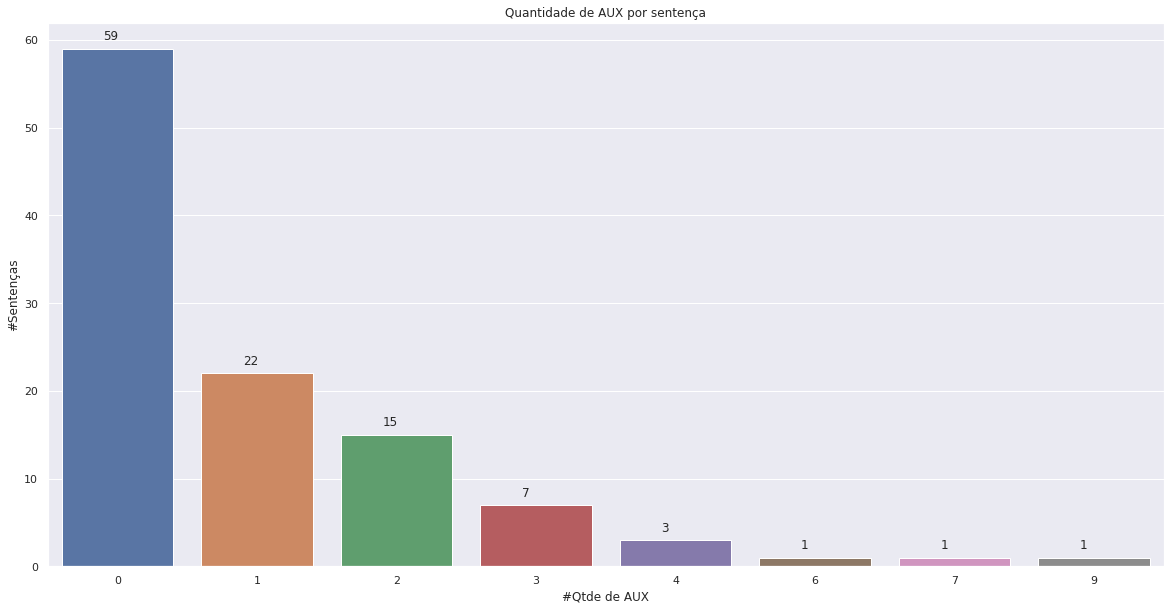

In [154]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

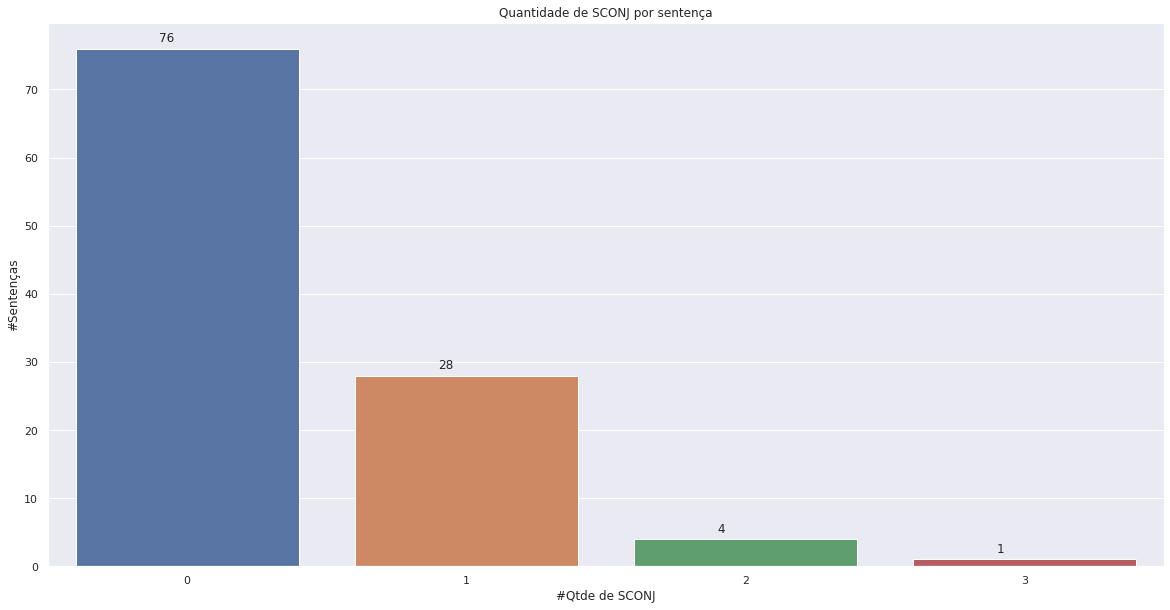

In [155]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

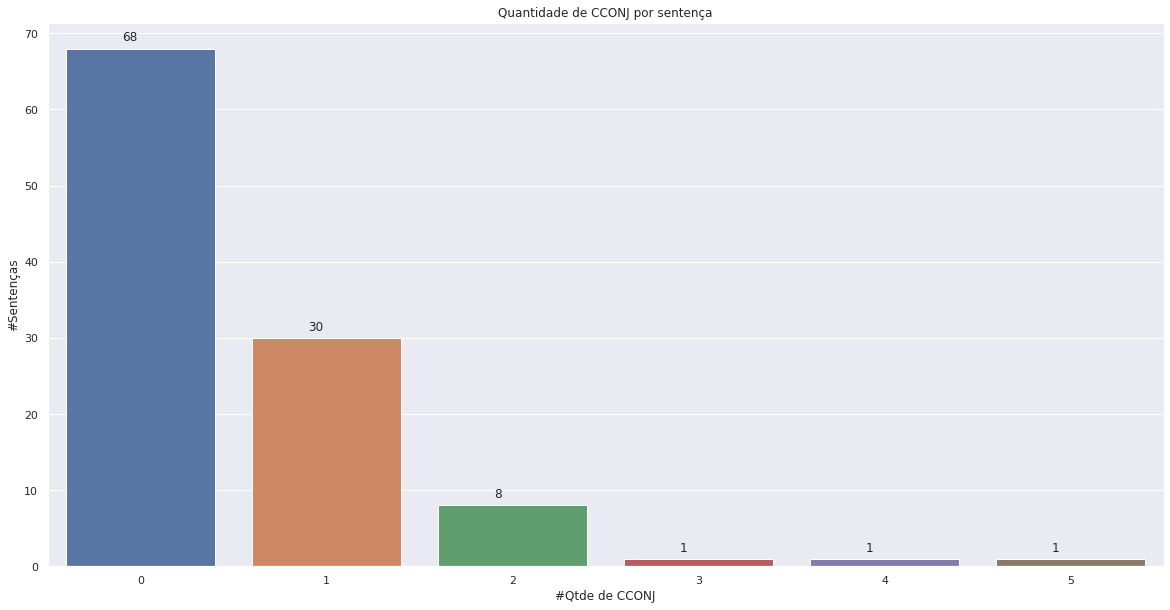

In [156]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

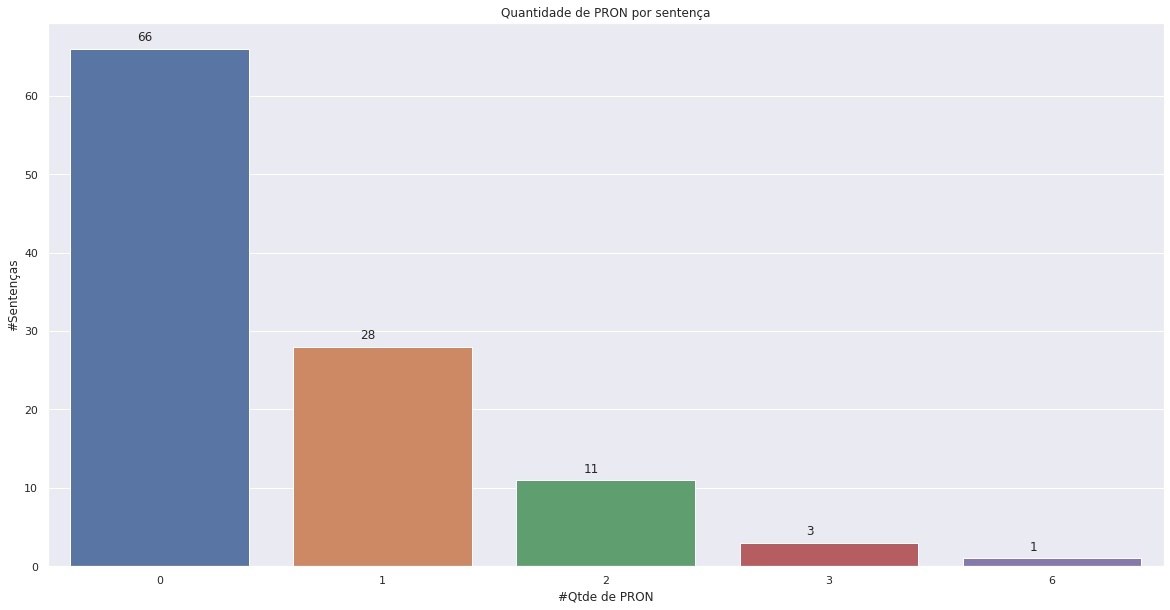

In [157]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Documento

#### 5.2.5.1 Gráfico Quantidade de documentos originais por quantidade de sentenças

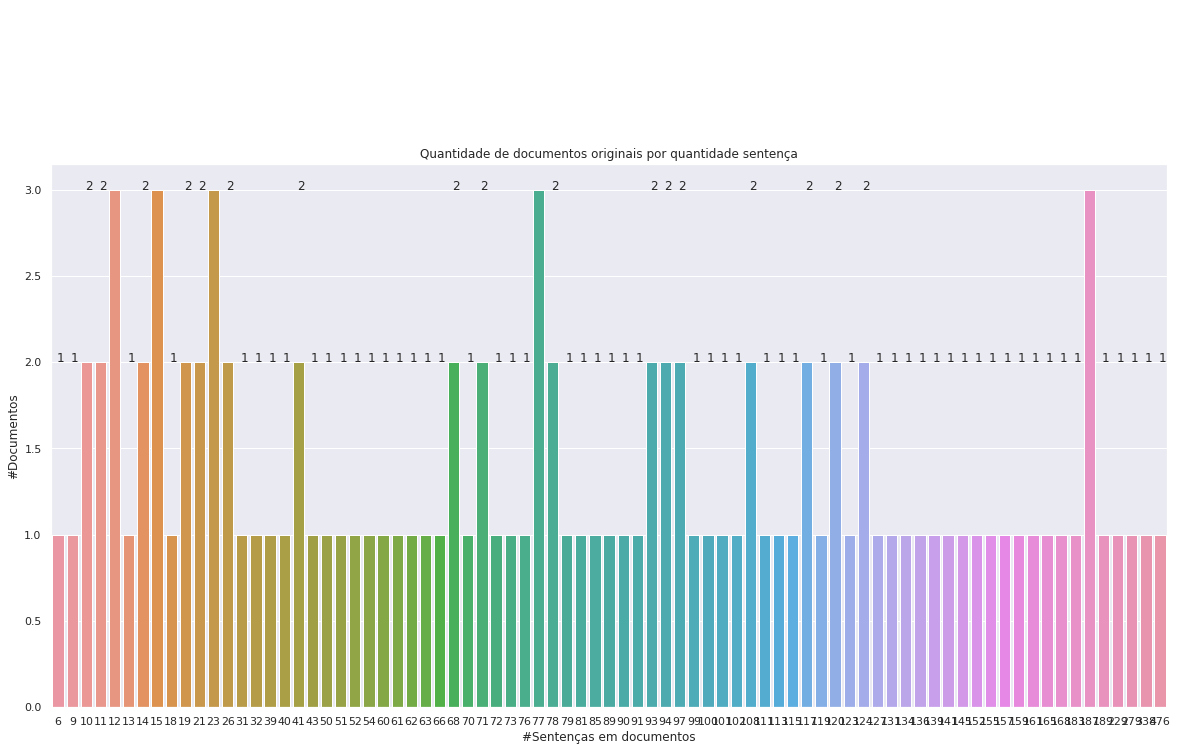

In [158]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.2 Gráfico Quantidade de documentos originais por quantidade de palavras

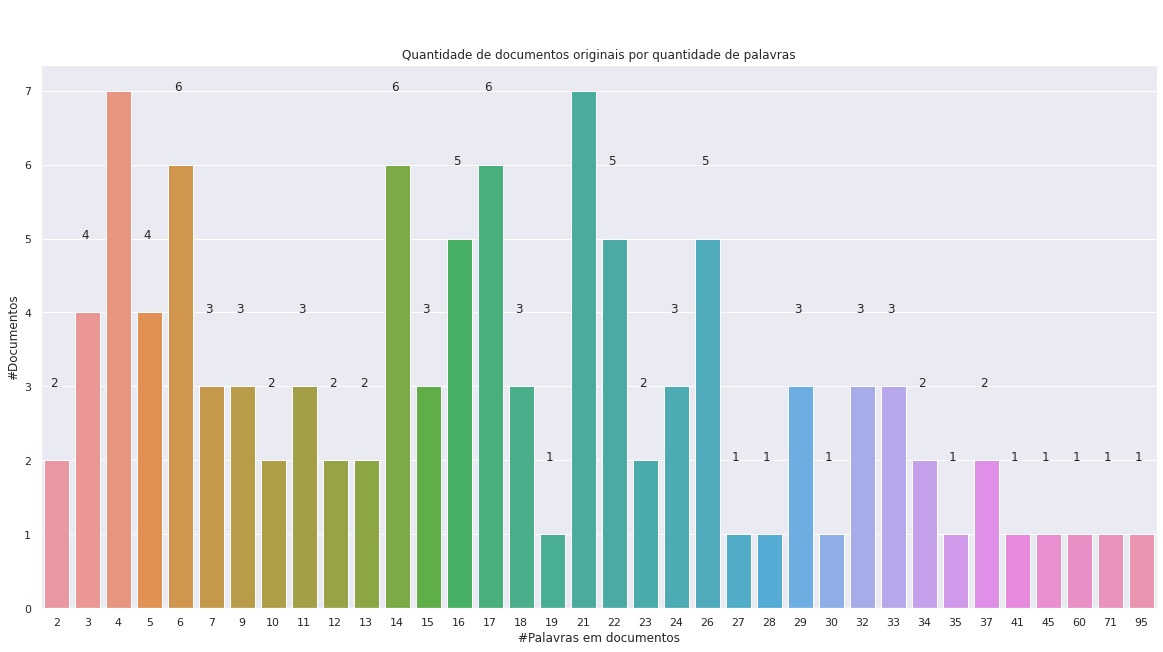

In [159]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.4 Gráfico Quantidade de documentos originais por quantidade de palavras desconsiderando as stopword

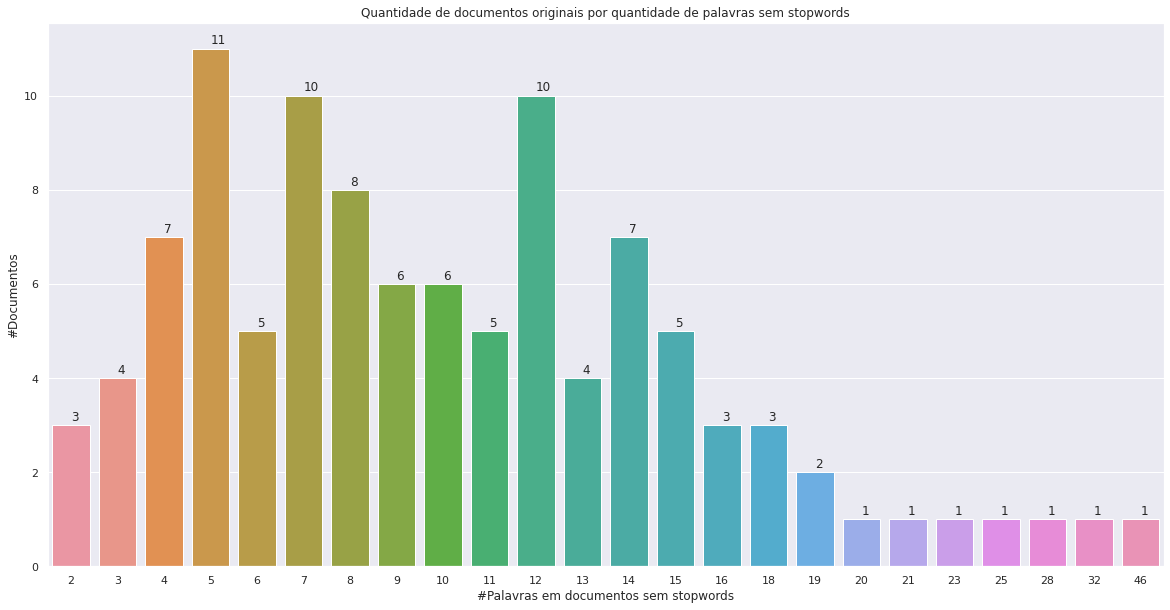

In [160]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.5 Gráfico Quantidade de documentos originais por quantidade de locuções verbais

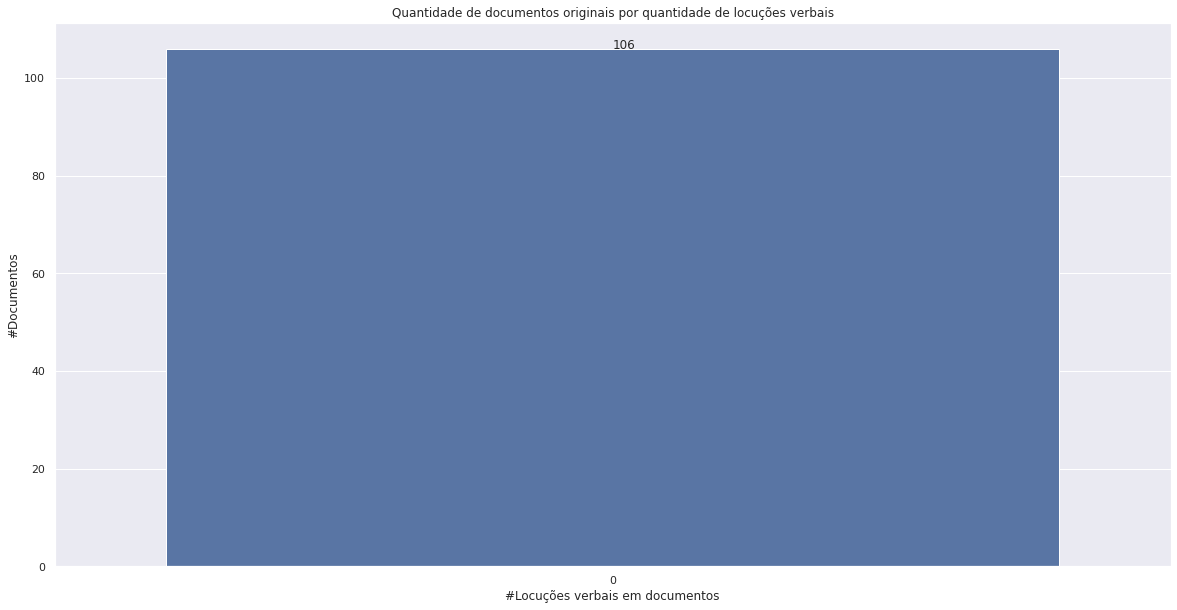

In [161]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.6 Gráfico Quantidade de documentos originais por quantidade de verbos

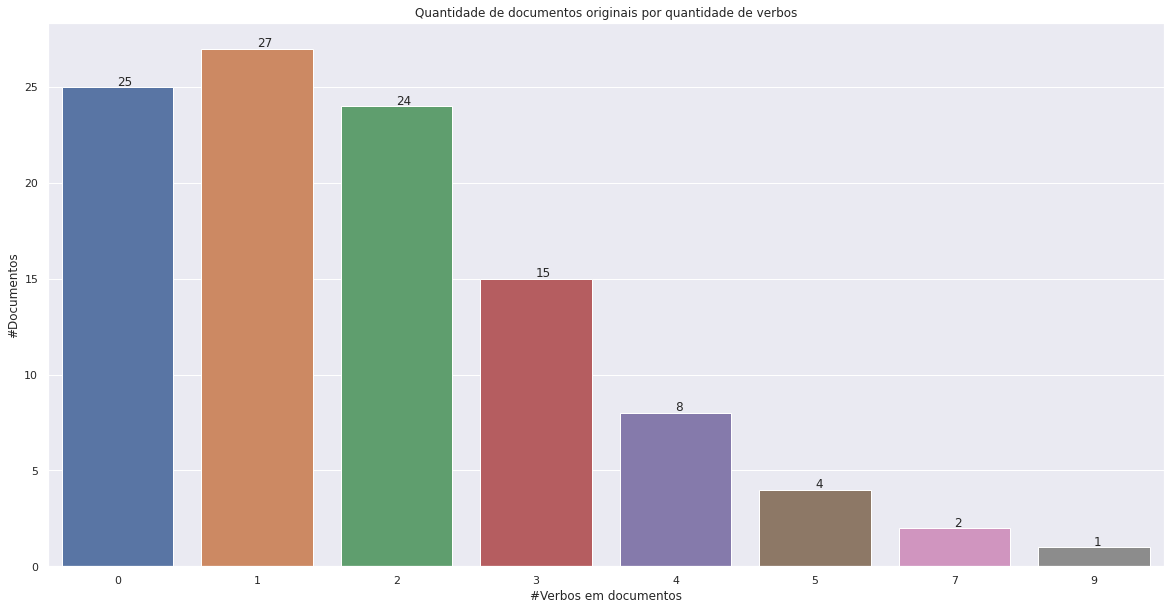

In [162]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.7 Gráfico Quantidade de documentos originais por quantidade de verbos e aux

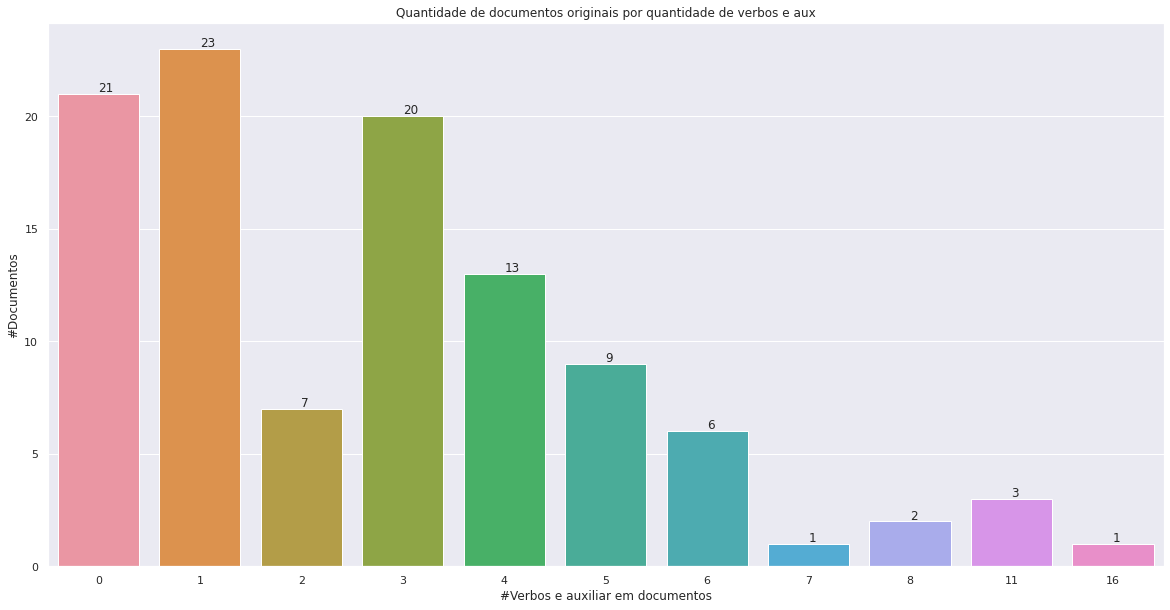

In [163]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.8 Gráfico Quantidade de documentos originais por quantidade de substantivos

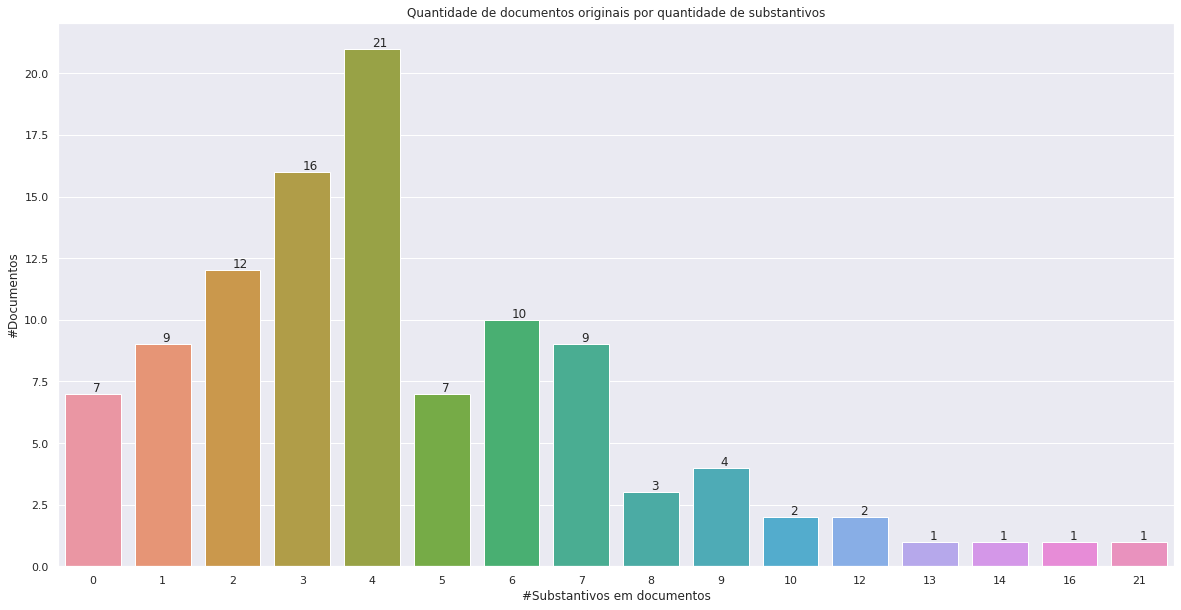

In [164]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.9 Gráfico Quantidade de documentos originais por quantidade de verbos(AUX) e substantivo

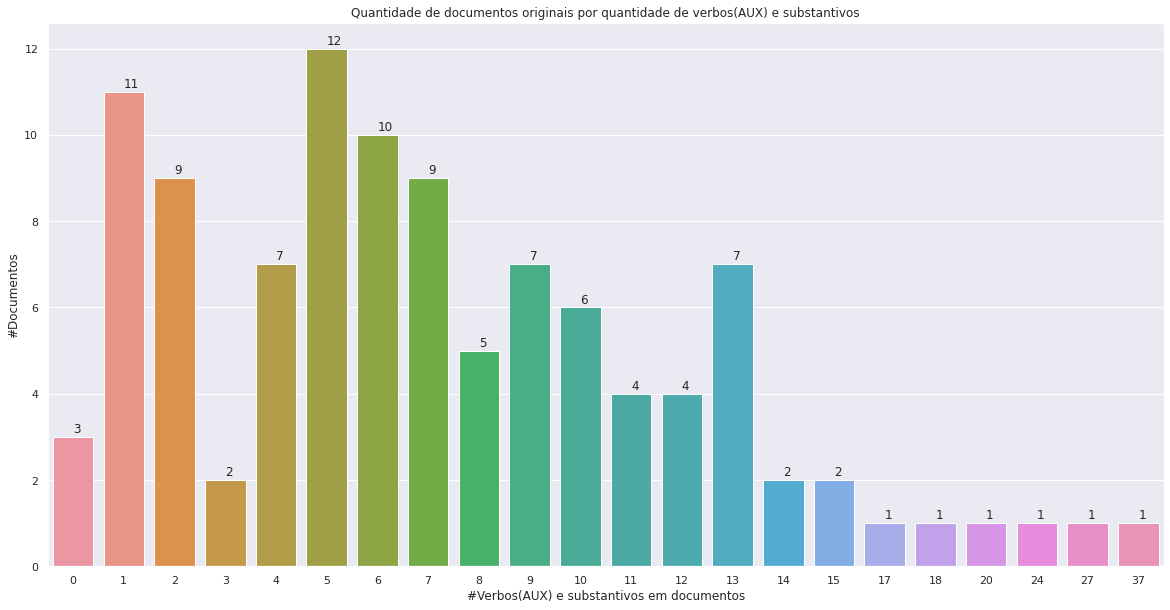

In [165]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

### 5.2.6 Por sentença

#### 5.2.6.1 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras

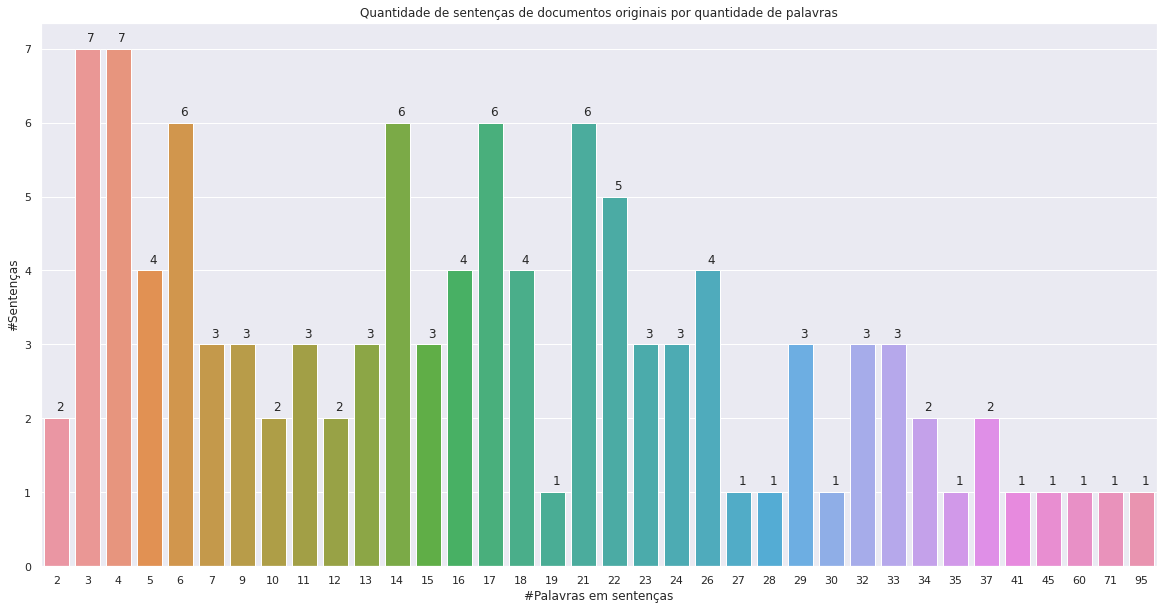

In [166]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopwords

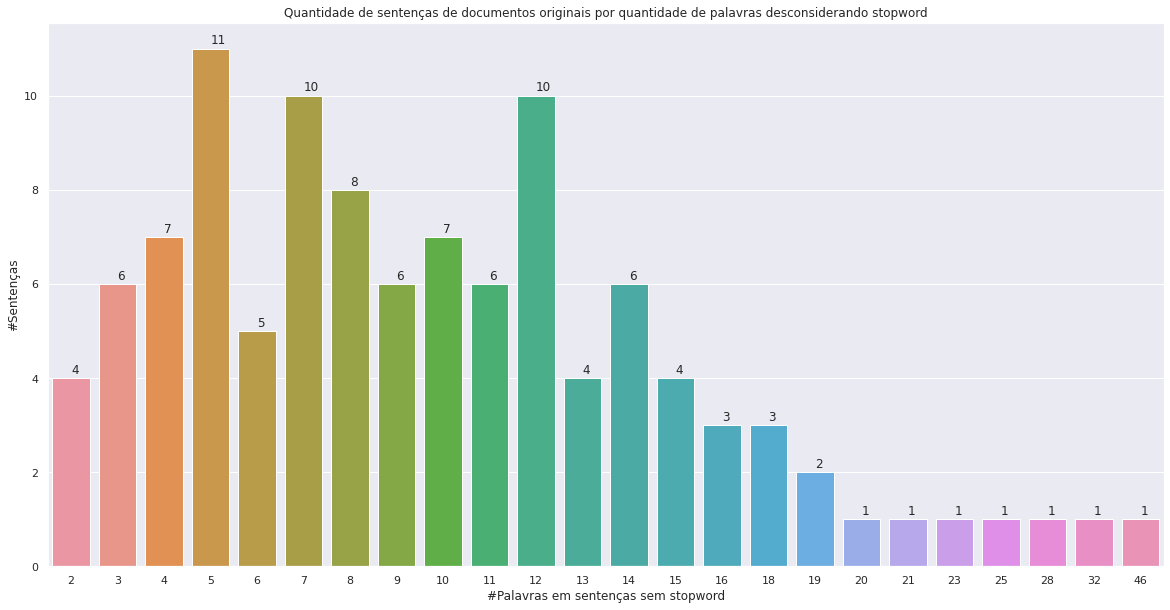

In [167]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos

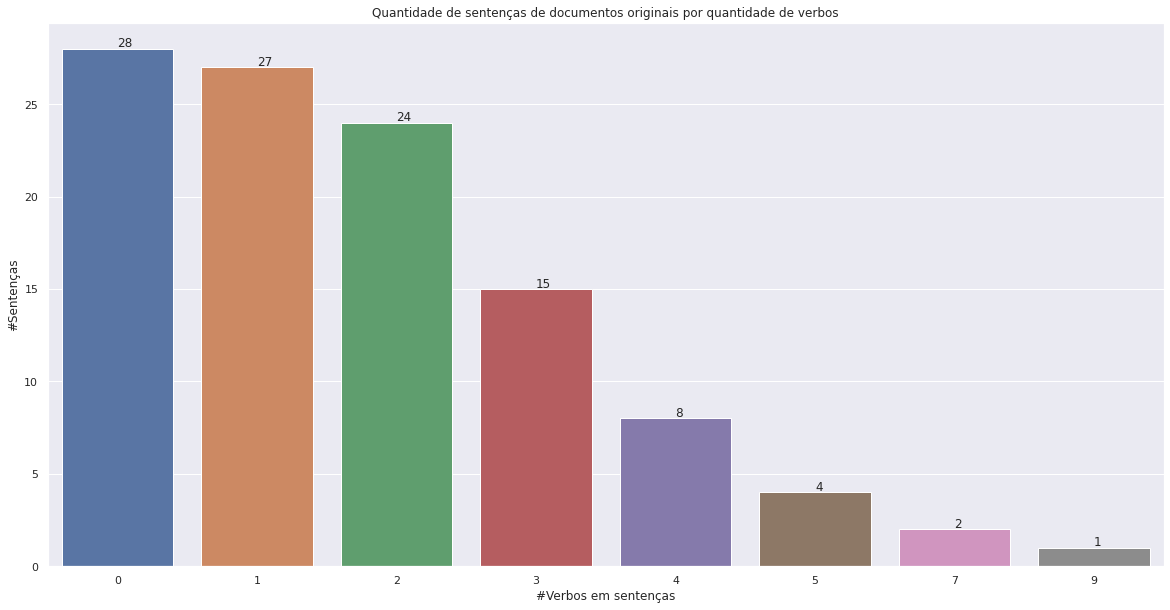

In [168]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos e aux

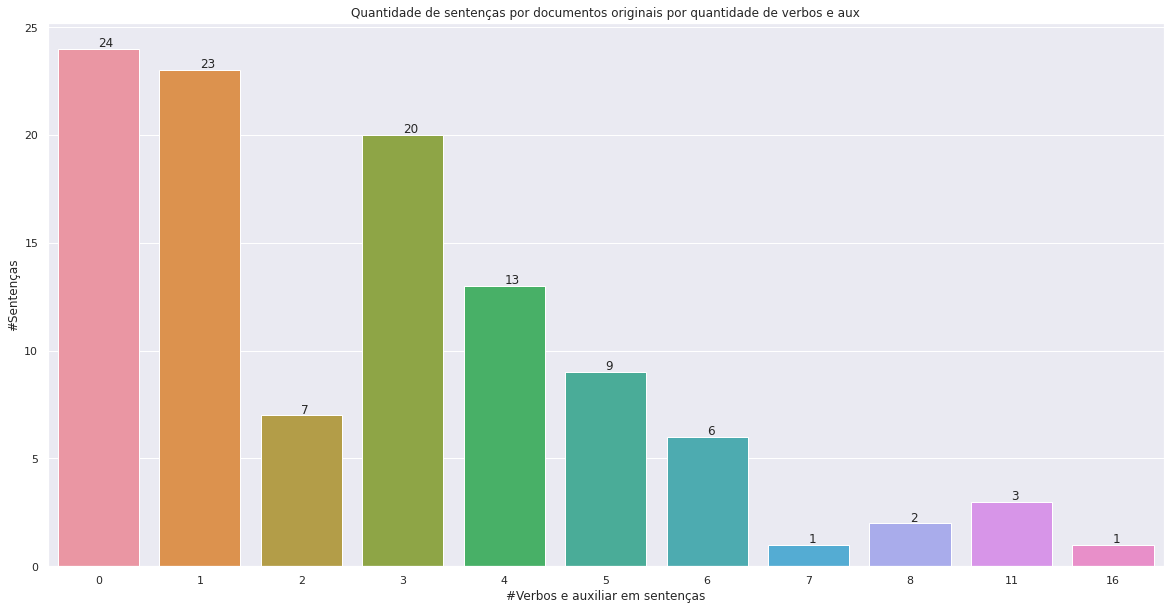

In [169]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de sentenças de documentos originais por quantidade de substantivos

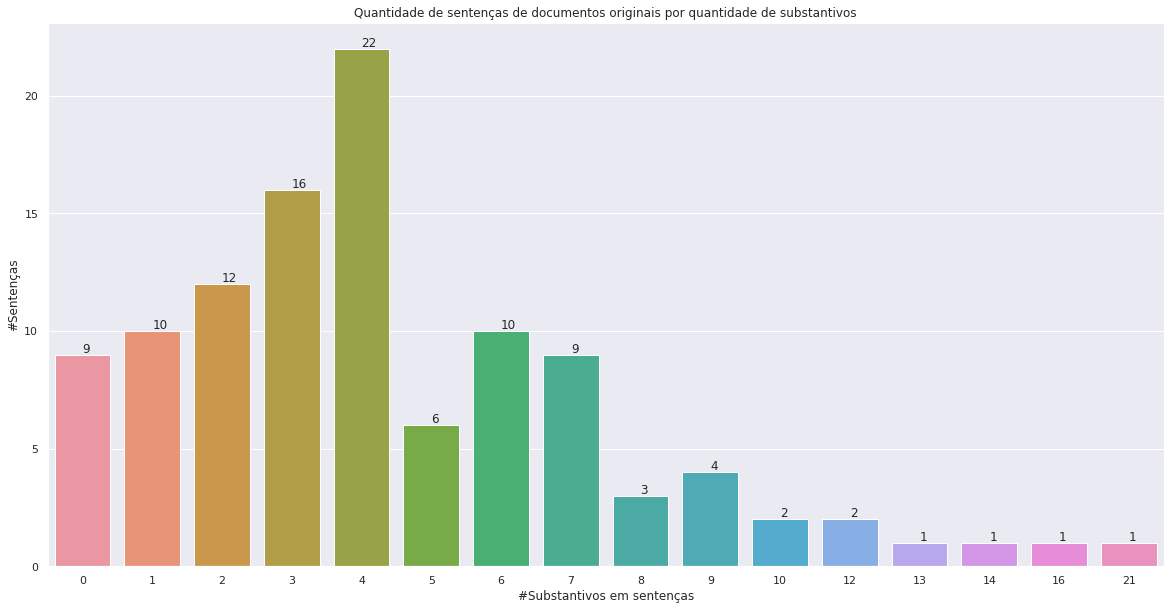

In [170]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivo

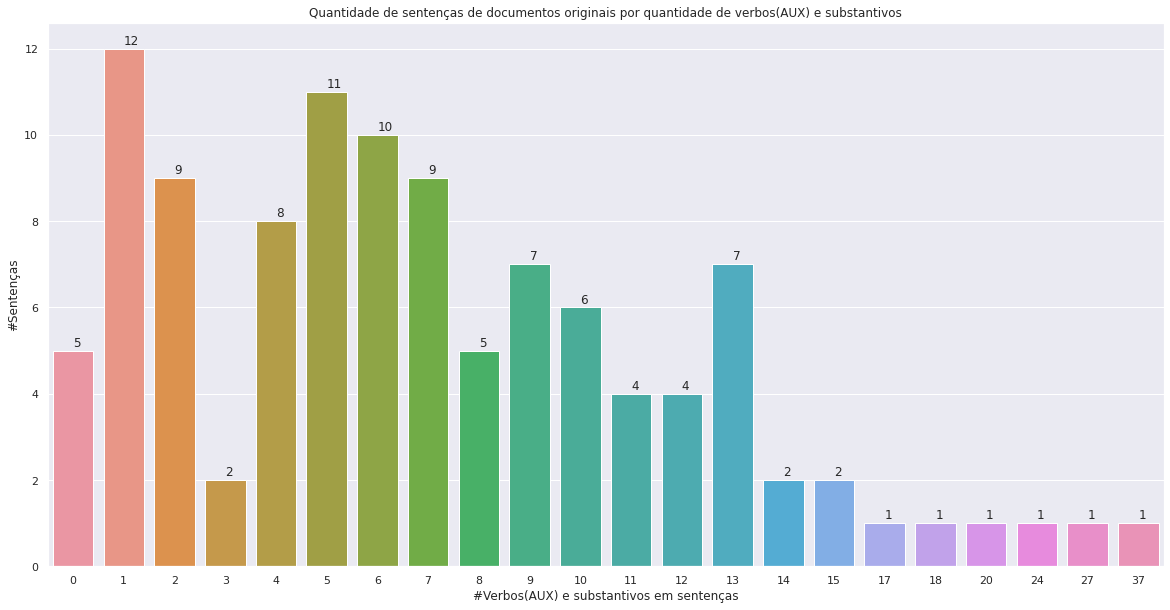

In [171]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento



In [172]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:02:54 (h:mm:ss)
